# Podstawy Przetwarzania Dużych Zbiorów Danych

Grupa IBD4 Poniedziałki 8:30

Łukasz Moskwa 247739

Artur Szewczykowski 252546


### 0.0 Importy i wczytanie do df

In [60]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df_data = pd.read_csv("../wyniki/final_data.csv")
df_data.rename(columns={"population_urban": "Urban Population", "Density (per km²)": "Density_per_km"}, inplace=True)
df_data = df_data.sort_values(by=['Country_name', 'date'])
df_data['Total_cases'] = df_data.groupby('Country_name')['Total_confirmed_cases'].cumsum()
df_data['Total_deceased'] = df_data.groupby('Country_name')['Total_new_deceased'].cumsum()
df_data['Total_vaccinations'] = df_data.groupby('Country_name')['Total_new_vaccinations'].cumsum()
df_data.to_csv("../wyniki/final_data.csv")

### Część 1 (poziom podstawowy) - wykresy pudełkowe

### 1.1.-1.3. Nowe zachorowania, śmierci, szczepienia i testy (1. dodatkowa kolumna)

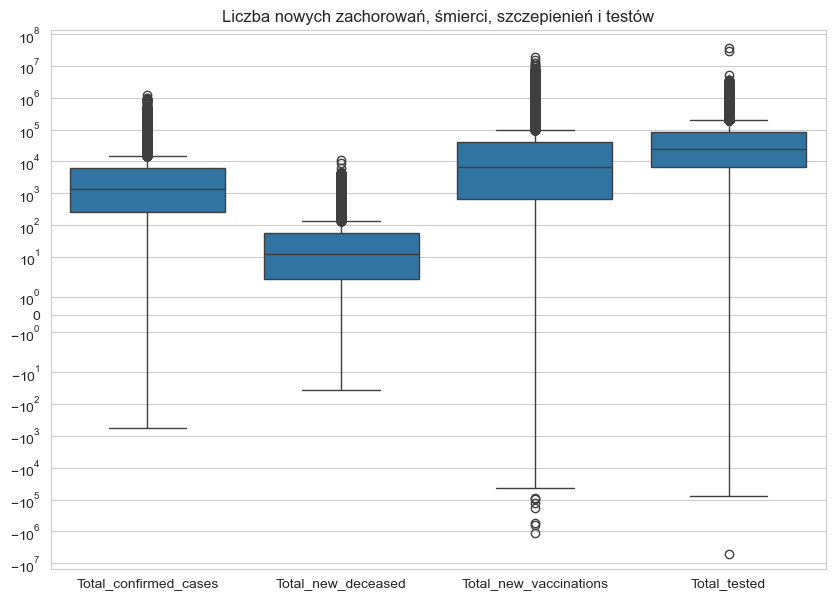

In [34]:
df_filtered = df_data.melt(
    value_vars=["Total_confirmed_cases", "Total_new_deceased", "Total_new_vaccinations", "Total_tested"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

plt.figure(figsize=(10, 7))
sns.boxplot(data=df_filtered, x="Metric", y="Cases")
plt.xlabel("")
plt.ylabel("")
plt.ylim(df_filtered["Cases"].min()-10000000, df_filtered["Cases"].max()+100000000)
plt.yscale("symlog")
plt.title("Liczba nowych zachorowań, śmierci, szczepienień i testów")

plt.show()

- Ujemne wartości, szczególnie w przypadku śmierci i szczepień, wydają się bardzo dziwne. O ile przy zachorowaniach faktycznie mogło dochodzić do np. poprawiania błędnych danych z poprzedniego dnia, kiedy ktoś został źle zaklasyfikowany, tak w przypadku śmierci, szczepień i testów trudno sobie wyobrazić, że ludzie zmartwychwstawali, "odszczepili się" albo "odtestowali".
- Widzimy bardzo długie zakresy dla wartości poniżej Q1 i stosunkowo krótkie dla powyżej Q3, czyli mamy do czynienia z tzw. "długim ogonem" i rozkładem nienormalnym, przesunięciem w prawo na osi czasu.

### 1.4. Populacja i populacja w miastach (2. dodatkowa kolumna)

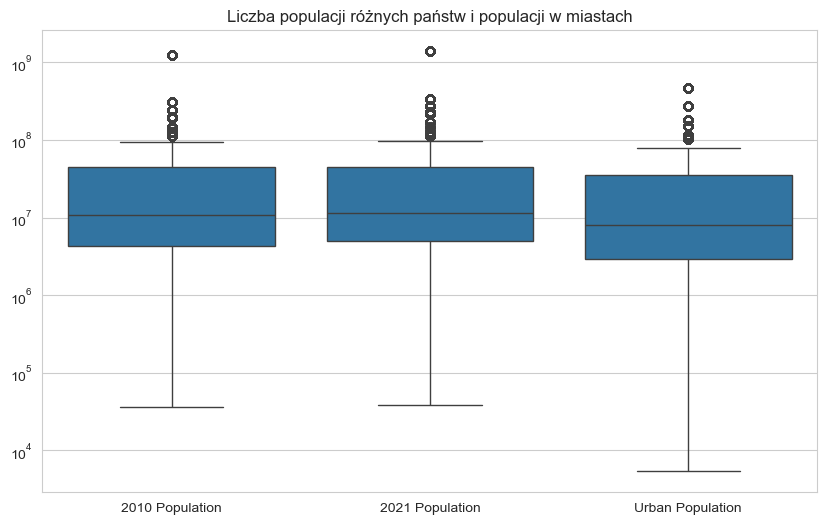

In [35]:
df_filtered = df_data.melt(
    value_vars=["2010 Population", "2021 Population", "Urban Population"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x="Metric", y="Cases")
plt.xlabel("")
plt.ylabel("")
plt.yscale("log")
plt.title("Liczba populacji różnych państw i populacji w miastach")

plt.show()

Populacja w miastach mniejsza niż całej ludzkości - zjawisko spodziewane, brak potencjalnych wartości odstających do usunięcia.

### 1.5. PKB

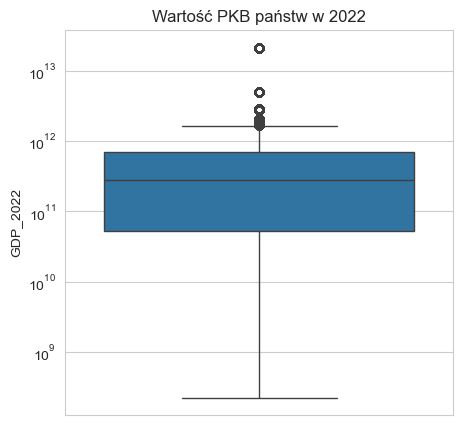

In [36]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df_data, y="GDP_2022")
plt.yscale("log")
plt.title("Wartość PKB państw w 2022")

plt.show()

Wygląda realistycznie - największe PKB świata - w bilionach (10^13) ma USA, a za nimi plasują się Chiny. W tym przypadku również usuwanie wartości skrajnych nic by nam nie dało, a wręcz ucięło by nam część ważnych danych.

### 1.6. Inflacja, bezrobocie i współczynnik morderstw - trzy dodatkowe kolumny

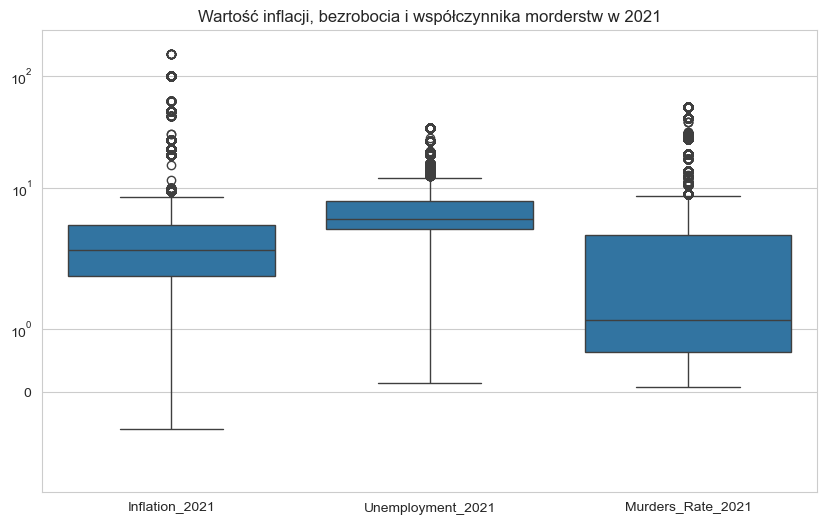

In [37]:
df_filtered = df_data.melt(
    value_vars=["Inflation_2021", "Unemployment_2021", "Murders_Rate_2021"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x="Metric", y="Cases")
plt.yscale("symlog")
plt.xlabel("")
plt.ylabel("")
plt.ylim(df_filtered["Cases"].min()-1, df_filtered["Cases"].max()+100)
plt.title("Wartość inflacji, bezrobocia i współczynnika morderstw w 2021")

plt.show()

Zakres wartości oraz wartości odstające wyglądają na realne, w tym także ujemne wartości inflacji, czyli deflacja.
Crimerate jest wartością mocno różniącą się pomiędzy krajami, bezrobocie - niezbyt.
Żadna z powyższych wartości nie wymaga raczej usuwania outlierów - są to wskaźniki społeczne/ekonomiczne, więc mogą zawierać pojedyncze przypadki mocno odbiegające od pozostałych, a wszystkie wartości jakie widzimy wydają się być realne.

W 2021 średnia roczna wartość inflacji była większa niż 100% w 4 krajach: w Wenezueli(686%), w Sudanie(331%), w Libanie(150%) i Zimbabwe(143%), więc nasze "peaki" są prawidłowe.

### 1.6.2 Kolejne dodatkowe kolumny

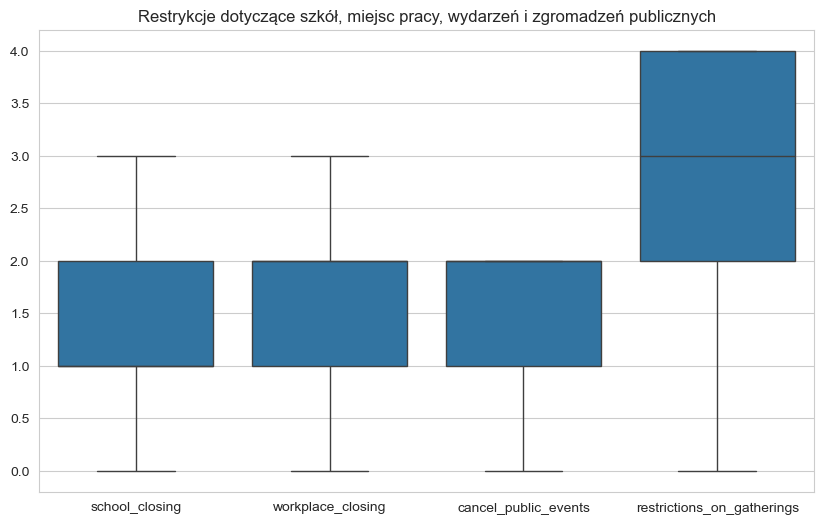

In [38]:
df_filtered = df_data.melt(
    value_vars=["school_closing", "workplace_closing", "cancel_public_events", "restrictions_on_gatherings"],
    var_name="Metric",
    value_name="Cases",
    ignore_index=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x="Metric", y="Cases")
plt.xlabel("")
plt.ylabel("")
plt.title("Restrykcje dotyczące szkół, miejsc pracy, wydarzeń i zgromadzeń publicznych")

plt.show()

Zgodnie z informacjami pozyskanymi w częśći 1. pierwsze dwa z tych parametrów przyjmują wartości liczb całkowitych z przedziału <0,3>, trzeci <0,2>, a ostatni <0,4>, co się zgadza.

### Część 2 (poziom dodatkowy) - outliery

Jedynymi sensowymi danymi do rozpatrywania pod kątem outlierów są w naszym przypadku liczby zachorowań, śmierci, szczepień i testów.

2.1 Metoda IQR
- rozstęp kwartylny/ćwiartkowy - przez to, że oparta na kwartylach to jest metoda bardziej odporna na skośność danych i dane, w których naturalnym jest szybki wzrost/spadek wartości (czyli takie dane jak śmierci czy szczepienia w trakcie pandemii)

In [39]:
def iqr(column, oryginal_length):
    df_filtered = df_data.copy()
    Q1 = df_filtered[column].quantile(0.25)
    Q3 = df_filtered[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    percentage = (len(df_filtered) / oryginal_length) * 100
    print(f'IQR: Pozostało {len(df_filtered)} wierszy czyli {percentage:.2f}% oryginalnych')
    return df_filtered


2.2 Metoda ZScore:
- oparta na odległości od średniej, więc lepiej się sprawdza przy danych z rozkładem normalnym (raczej nie naszych).

In [40]:
def zscore(column, threshold, oryginal_length):
    df_filtered = df_data.copy()
    mean = df_filtered[column].mean()
    std = df_filtered[column].std()
    df_filtered['Z_Score'] = (df_filtered[column] - mean) / std
    df_filtered = df_filtered[np.abs(df_filtered['Z_Score']) <= threshold]
    df_filtered = df_filtered.drop(columns=['Z_Score'])
    percentage = (len(df_filtered) / oryginal_length) * 100
    print(f'Z-Score ({threshold}): Pozostało {len(df_filtered)} wierszy, czyli {percentage:.2f}% oryginalnych')
    return df_filtered

In [41]:
columns = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations', 'Total_tested']
oryginal_length = len(df_data)
print(f'Przed usuwaniem wartości odstających było {len(df_data)} wierszy')
for col in columns:
     print(f'\nUsuwanie wartości odstających z kolumny {col}:')
     df_iqr = iqr(col, oryginal_length)
     df_zscore_2 = zscore(col, 2, oryginal_length)
     df_zscore_3 = zscore(col, 3, oryginal_length)

Przed usuwaniem wartości odstających było 31440 wierszy

Usuwanie wartości odstających z kolumny Total_confirmed_cases:
IQR: Pozostało 26782 wierszy czyli 85.18% oryginalnych
Z-Score (2): Pozostało 30707 wierszy, czyli 97.67% oryginalnych
Z-Score (3): Pozostało 30999 wierszy, czyli 98.60% oryginalnych

Usuwanie wartości odstających z kolumny Total_new_deceased:
IQR: Pozostało 26945 wierszy czyli 85.70% oryginalnych
Z-Score (2): Pozostało 30573 wierszy, czyli 97.24% oryginalnych
Z-Score (3): Pozostało 30823 wierszy, czyli 98.04% oryginalnych

Usuwanie wartości odstających z kolumny Total_new_vaccinations:
IQR: Pozostało 25974 wierszy czyli 82.61% oryginalnych
Z-Score (2): Pozostało 30152 wierszy, czyli 95.90% oryginalnych
Z-Score (3): Pozostało 30382 wierszy, czyli 96.63% oryginalnych

Usuwanie wartości odstających z kolumny Total_tested:
IQR: Pozostało 27045 wierszy czyli 86.02% oryginalnych
Z-Score (2): Pozostało 30412 wierszy, czyli 96.73% oryginalnych
Z-Score (3): Pozostało 30893 wi

- IQR wszędzie usuwał zdecydowanie większą liczbę wartości odstających niż Z-Score - aby odpowiedzieć czy to dobrze wypadałoby zrobić jeszcze boxploty wszystkich wyników po tych usunięciach i porównać z pierwotnymi, ale sądząc po teorii usunięcie IQR było lepsze.
- W przypadku zachorowań, śmierci i testów zostały usunięte porównywalne ilości wartości w każdej z metod.
- W przypadku liczby szczepień zostało usunięte trochę więcej wierszy (można się było spodziewać tego po boxplotach, które wyszły w części 1.)

### Część 3 (poziom podstawowy) - obliczenia statystyczne

### 3.0. Wybór 10 państw i zakresu dat

In [42]:
countries = ["Lithuania", "Slovakia", "Latvia", "Greece", "Hungary",
                      "Poland", "Croatia", "Bulgaria", "Russia", "Turkey"]

df_filtered = df_data[
    (df_data["Country_name"].isin(countries)) &
    (df_data["date"].str.startswith("2021-04"))].copy()
display (df_filtered)

,Country_name,3_letter_code,Urban Population,gdp_per_capita_usd,GDP_2022,date,Total_confirmed_cases,Total_new_deceased,Total_new_vaccinations,New_persons_fully_vaccinated,...,Murders_Rate_2012,Murders_Rate_2013,Murders_Rate_2014,Murders_Rate_2015,Murders_Rate_2016,Murders_Rate_2017,Murders_Rate_2018,Murders_Rate_2019,Murders_Rate_2020,Murders_Rate_2021
703,Greece,GRC,8507474.0,20296.0,2.176665e+11,2021-04-01,3058,72,21730.0,17514.0,...,1.514096,1.401804,0.984998,0.860582,0.781414,0.804323,0.93104,0.737657,0.741993,0.852053
704,Greece,GRC,8507474.0,20296.0,2.176665e+11,2021-04-02,3229,70,21222.0,17228.0,...,1.514096,1.401804,0.984998,0.860582,0.781414,0.804323,0.93104,0.737657,0.741993,0.852053
705,Greece,GRC,8507474.0,20296.0,2.176665e+11,2021-04-03,1955,78,35835.0,17025.0,...,1.514096,1.401804,0.984998,0.860582,0.781414,0.804323,0.93104,0.737657,0.741993,0.852053
706,Greece,GRC,8507474.0,20296.0,2.176665e+11,2021-04-05,4293,79,51262.0,4746.0,...,1.514096,1.401804,0.984998,0.860582,0.781414,0.804323,0.93104,0.737657,0.741993,0.852053
707,Greece,GRC,8507474.0,20296.0,2.176665e+11,2021-04-06,3445,75,47256.0,12713.0,...,1.514096,1.401804,0.984998,0.860582,0.781414,0.804323,0.93104,0.737657,0.741993,0.852053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31047,Turkey,TUR,63097818.0,9042.0,7.414791e+11,2021-04-26,37312,353,115723.0,148099.0,...,4.272196,NaN,NaN,2.806161,3.337472,3.095390,2.60961,2.419692,2.505484,2.519599
31048,Turkey,TUR,63097818.0,9042.0,7.414791e+11,2021-04-27,43301,346,95330.0,188346.0,...,4.272196,NaN,NaN,2.806161,3.337472,3.095390,2.60961,2.419692,2.505484,2.519599
31049,Turkey,TUR,63097818.0,9042.0,7.414791e+11,2021-04-28,40444,341,129773.0,324569.0,...,4.272196,NaN,NaN,2.806161,3.337472,3.095390,2.60961,2.419692,2.505484,2.519599
31050,Turkey,TUR,63097818.0,9042.0,7.414791e+11,2021-04-29,37674,339,133588.0,301781.0,...,4.272196,NaN,NaN,2.806161,3.337472,3.095390,2.60961,2.419692,2.505484,2.519599


3.0.1. Dobór państw - wybraliśmy 10 europejskich państw (podobny region geograficzny, kulturowy) z PKB per capita najbardziej zbliżonym do Polski w roku 2021. (źródło - Międzynarodowy Fundusz Walutowy). Co prawda zamiast Turcji powinna być Rumunia, ale nie zbierała ona danych dotyczących liczby przeprowadzanych testów, a jest to jeden z aspektów, który będziemy analizować, dlatego nie pobraliśmy danych z tego kraju.

3.0.2. Dobór daty - kwiecień 2021 to rok po tym jak wirus Covid-19 przedostał się do Europy. Dlatego pamiętajmy, że nasze wykresy będą pokazywały jak władze i społeczeństwa poszczególnych państw radziły sobie po roku życia w pandemii. Jednocześnie jest to czas, kiedy szczepionki były już szeroko dostępne.

3.0.3. Dane z Rosji - jako państwa autorytarnego i odnoszącego się niezbyt przychylnie do Zachodu i organizacji międzynarodowych można traktować z lekką dozą dystansu.

3.0.4. Dane dla Grecji pochodzą z 20 dni. Reszta państw posiada zbiory z ok. 24-30 dni.

3.0.5. Dane, które będziemy analizować w kolejnych punktach mocno są związane z liczbą ludności danego państwa, dlatego zanim przejdziemy do części właściwej warto zobrazować z jakim zróżnicowaniem tej wartości mamy do czynienia:

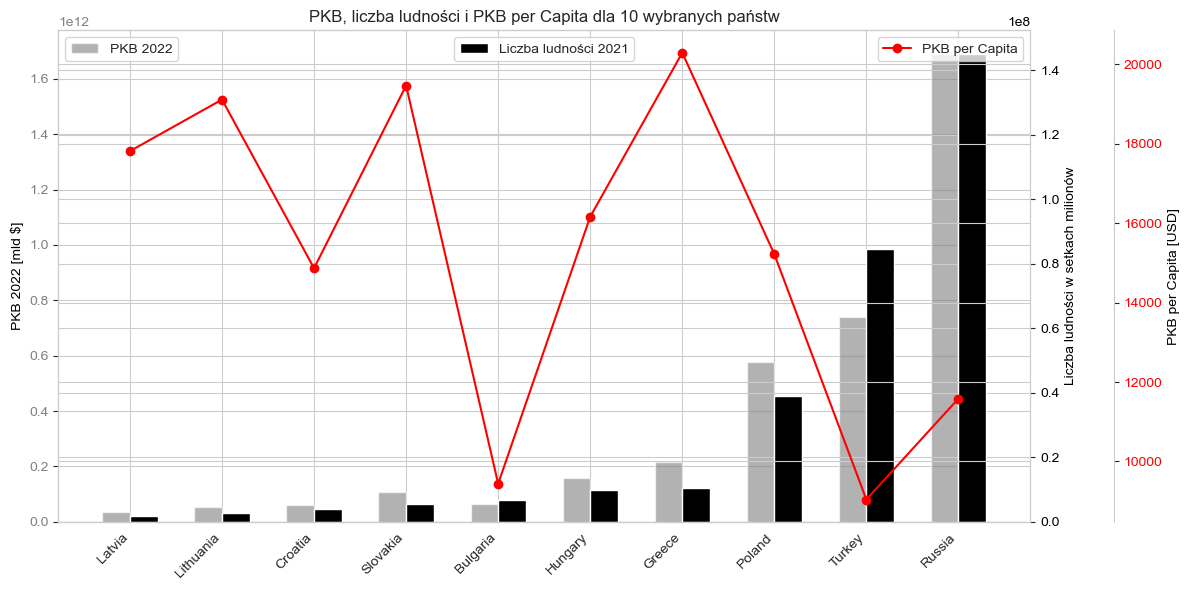

In [43]:
summary_stats = df_filtered.groupby("Country_name").agg({
    "2021 Population": "first",
    "GDP_2022": "first",
    "gdp_per_capita_usd": "first"
}).sort_values(by="2021 Population")

countries = summary_stats.index
population = summary_stats["2021 Population"]
gdp = summary_stats["GDP_2022"]
gdp_per_capita = summary_stats["gdp_per_capita_usd"]

x = np.arange(len(countries))
width = 0.3

fig, ax1 = plt.subplots(figsize=(12, 6))

ax3 = ax1.twinx()
ax3.bar(x + width/2, population, width=width, color="black", label="Liczba ludności 2021")
ax3.set_ylabel("Liczba ludności w setkach milionów", color="black")
ax3.tick_params(axis="y", labelcolor="black")

ax1.bar(x - width/2, gdp, width=width, color="gray", label="PKB 2022", alpha=0.6)
ax1.set_ylabel("PKB 2022 [mld $]", color="black")
ax1.tick_params(axis="y", labelcolor="gray")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("outward", 60))
ax2.plot(x, gdp_per_capita, color="red", marker="o", linestyle="-", label="PKB per Capita")
ax2.set_ylabel("PKB per Capita [USD]", color="black")
ax2.tick_params(axis="y", labelcolor="red")

ax1.set_xticks(x)
ax1.set_xticklabels(countries, rotation=45, ha="right")

ax1.set_title("PKB, liczba ludności i PKB per Capita dla 10 wybranych państw")
ax1.legend(loc="upper left")
ax3.legend(loc="upper center")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()

1. Liczba ludności Polski, Turcji i Rosji zdecydowanie odstaje od wartości dla pozostałych państw. Jednocześnie te trzy państwa także mocno się różnią w stosunku ok. 1:2:3. Dlatego też jeżeli będziemy analizować liczby bezwzględne, to trzeba mieć na uwadze powyższe dysproporcje.
2. Pod względem PKB Polska jest dużo bliżej Turcji niż pod względem ludności, z kolei Bułgaria pomimo dużej liczebności PKB ma zbliżone do tego Łotwy i Litwy.
3. Ze względu na PKB per capita możemy podzielić państwa na trzy grupy:
- Wysokie: Grecja, Słowacja, Litwa, Łotwa,
- Średnie: Węgry, Polska, Chorwacja,
- Niskie: Rosja, Bułgaria, Turcja. <br>
Tak też powinna kształtować się jakość radzenia sobie z pandemią.
### 3.1. Średnia liczba zachorowań, śmierci i szczepień

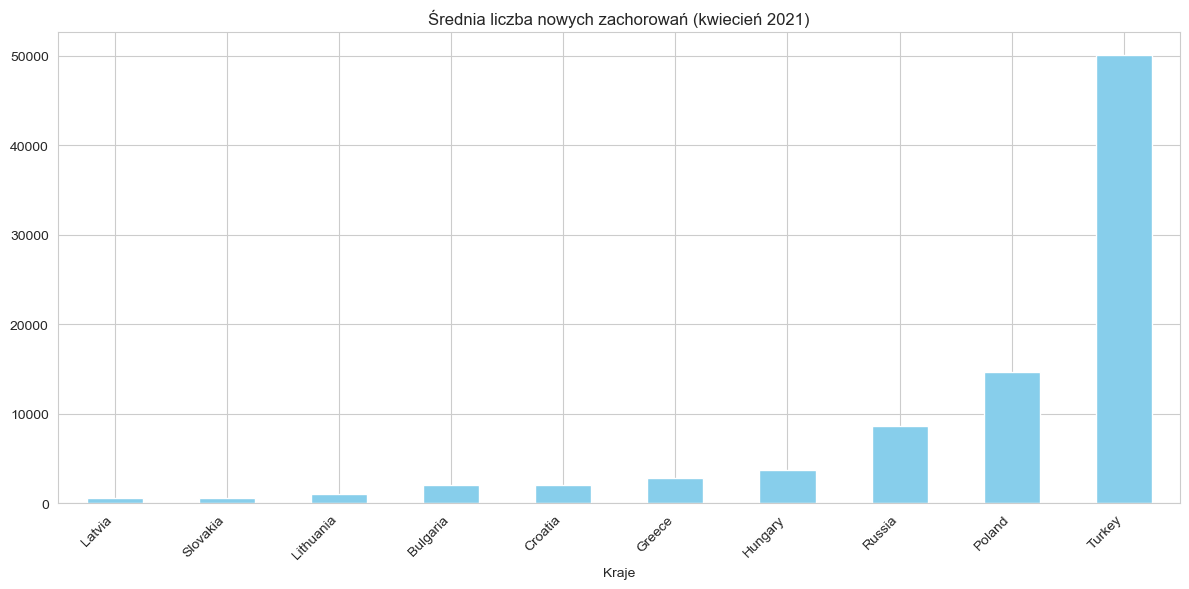

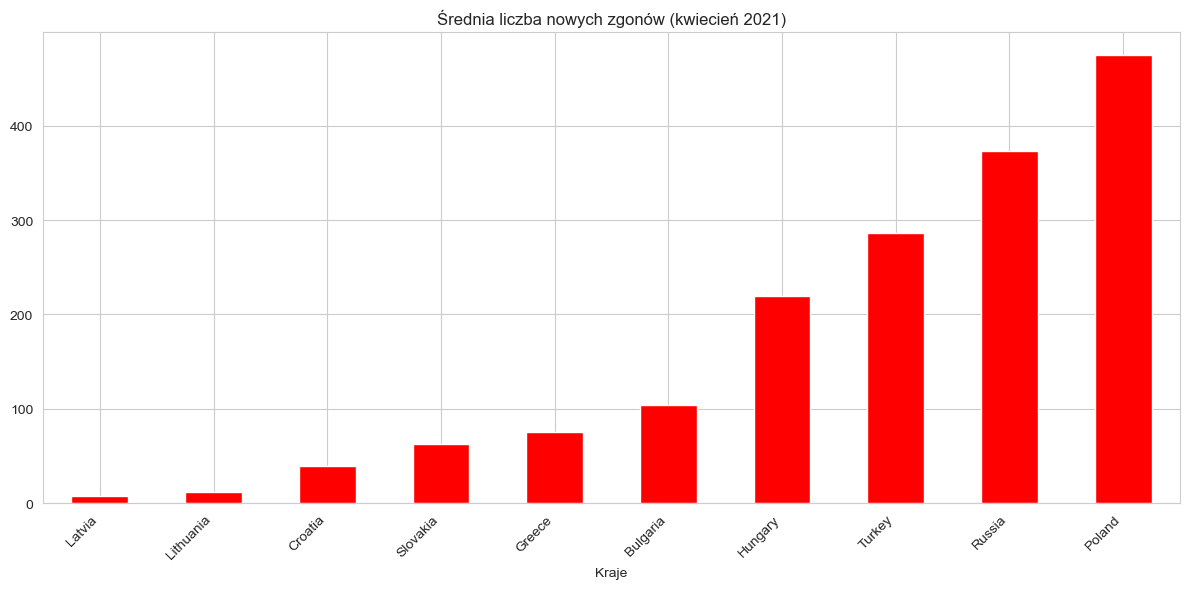

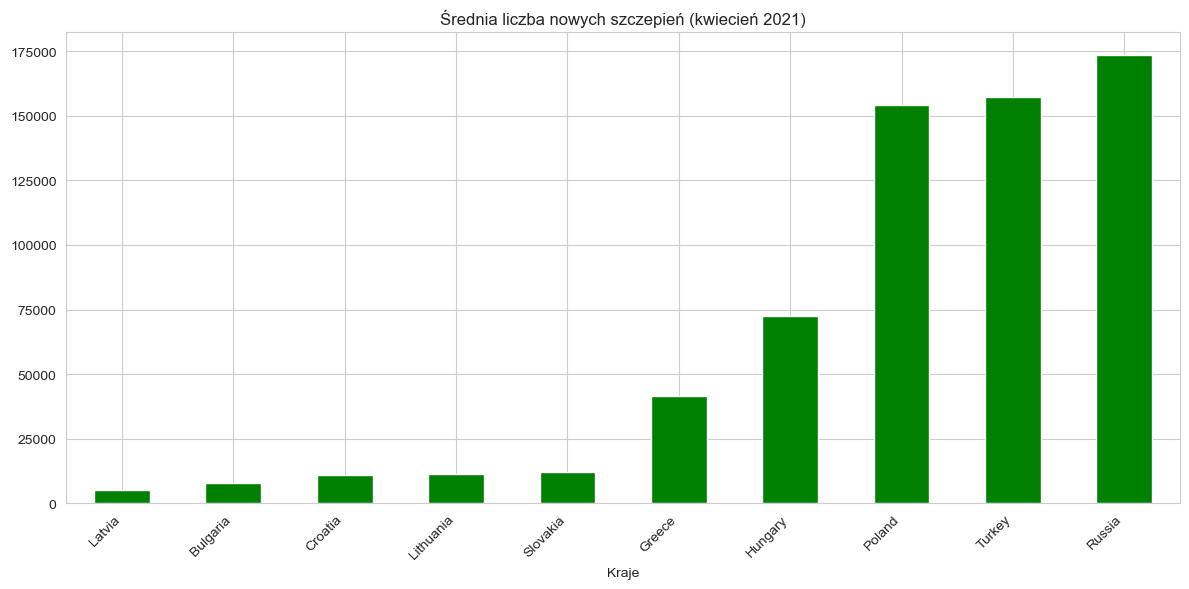

In [44]:
# 3.1.1. Średnia liczba nowych zachorowań
confirmed = df_filtered.groupby("Country_name")["Total_confirmed_cases"].mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue")
plt.title("Średnia liczba nowych zachorowań (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.1.2. Średnia liczba nowych zgonów
deceased = df_filtered.groupby("Country_name")["Total_new_deceased"].mean().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Średnia liczba nowych zgonów (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.1.3. Średnia liczba nowych szczepień
vaccinations = df_filtered.groupby("Country_name")["Total_new_vaccinations"].mean().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Średnia liczba nowych szczepień (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1. Jak widać w przypadku liczb bewzględnych można powiedzieć, że grupa 3 najludniejszych krajów dominuje w statystykach, a te najmniej liczne - zajmują ostatnie pozycje. Co prawda patrząc po liczbie ludności można by było spodziewać się dużo większej liczby zachorowań dla Rosji, ale jest to kraj z jedną z najniższych gęstości zaludnienia na świecie.
2. Na wykresie nr 1 widać, że liczba nowych zachorowań w Turcji zdecydowanie odbiegała od pozostalych państw.
3. Niepokojący może być dla nas wykres nr 2 - Polska zajmuje niechlubne 1. miejsce pomimo posiadania nienajwiększej liczby ludności. Pozostałymi państwami, w których było najwięcej zgonów to Rosja, Turcja i Węgry.
4. Najwięcej szczepień przeprowadzono w najliczniejszych państwach - logiczne.


### 3.2. Średnia różnica dziennych zachorowań, śmierci i szczepień
czyli jak bardzo zmieniała się dzienna liczba przypadków w czasie?

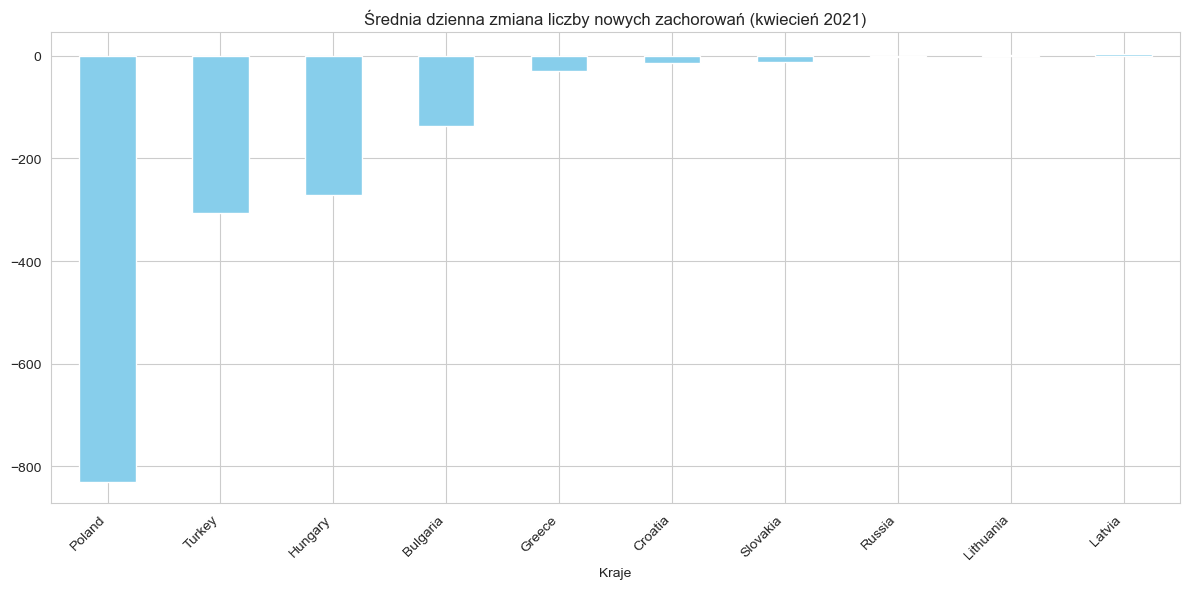

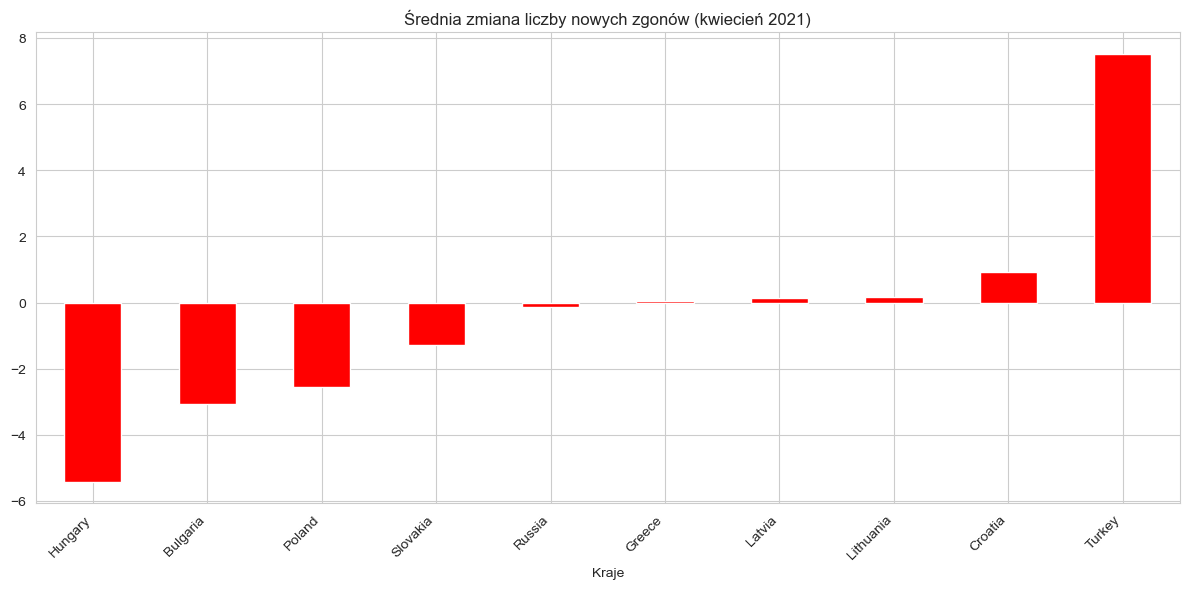

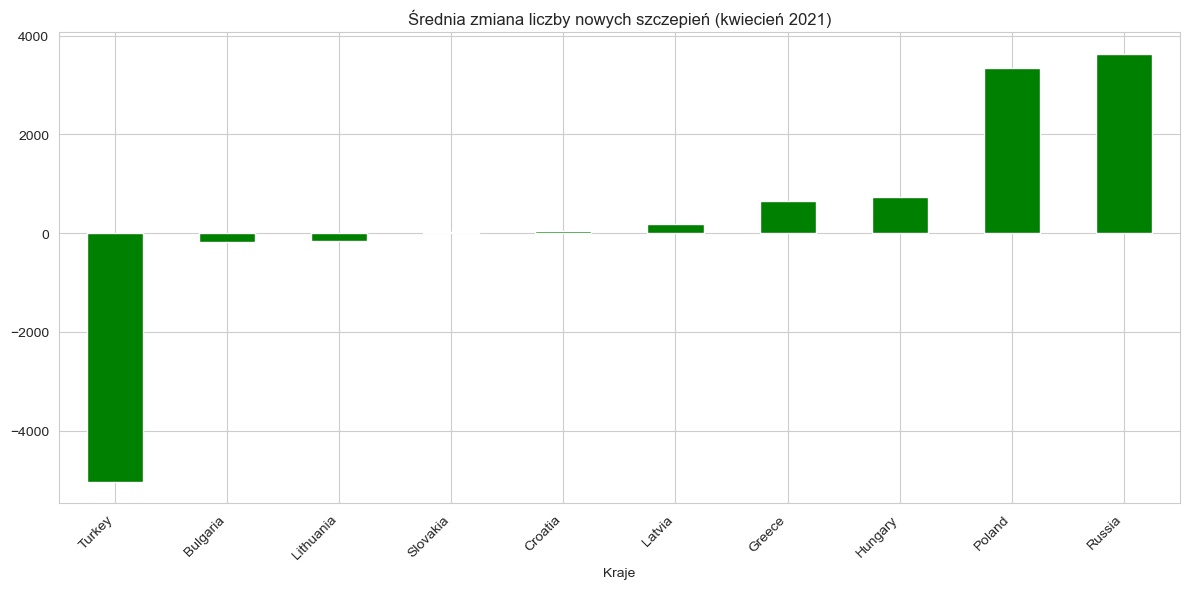

In [45]:
# 3.2.1. Średnia różnica nowych zachorowań
confirmed = df_filtered.groupby("Country_name")["Total_confirmed_cases"].diff().groupby(df_filtered["Country_name"]).mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue")
plt.title("Średnia dzienna zmiana liczby nowych zachorowań (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kraje")
plt.tight_layout()
plt.show()

# 3.2.2. Średnia różnica dziennych śmierci
deceased = df_filtered.groupby("Country_name")["Total_new_deceased"].diff().groupby(df_filtered["Country_name"]).mean().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Średnia zmiana liczby nowych zgonów (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.2.3. Średnia różnica dziennych testów
vaccinations = df_filtered.groupby("Country_name")["Total_new_vaccinations"].diff().groupby(df_filtered["Country_name"]).mean().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Średnia zmiana liczby nowych szczepień (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1. Zachorowania - w większości państw tendencja spadkowa.
- Szczególnie w Polsce liczba zachorowań pomiędzy początkiem a końcem kwietnia spadła szczególnie mocno, podobny trend widać również m.in. w Turcji, na Węgrzech i w Bułgarii.
- W takich krajach jak w Rosji, Chorwacji, Litwie, Łotwie i Słowacji liczba zachorowań utrzymywała się na podobnym poziomie w skali miesiąca.
2. Śmierci - we wszystkich krajach oprócz Turji i Chorwacji tendencja bliska zeru lub spadkowa, co oznacza, biorąc pod uwagę także wykresy z wcześniejszego podpunktu że:
- w Polsce, Rosji, Bułgarii i na Węgrzech liczba śmierci była największa na początku miesiąca, a potem wzglednie spadała.
- W Turcji było odwrotnie (dużo na koniec kwietnia).
- W pozostałych państwach liczba zgonów była na względnie stałym poziomie.
3. Szczepienia - we wszystkich krajach oprócz Turcji tendencja wzrostowa, co oznacza, że:
- Turcja szczepiła bardzo dużo osób na początku kwietnia (patrz wcześniejszy wykres), a potem ta tendencja spadła, co jest lekko dziwne, co nie zapobiegło bardzo dużej śmiertelności w 2. części miesiąca.
- Polska i Rosja szczepiły z każdym dniem coraz więcej osób, co nie dziwi biorąc pod uwagę liczbę ludności tych państw. Do tego grona można też zaliczyć Grecję i Węgry.
- Pozostałe państwa utrzymywały względnie stałą liczbę szczepień.

### 3.3. Mediana nowych zachorowań, śmierci i szczepień

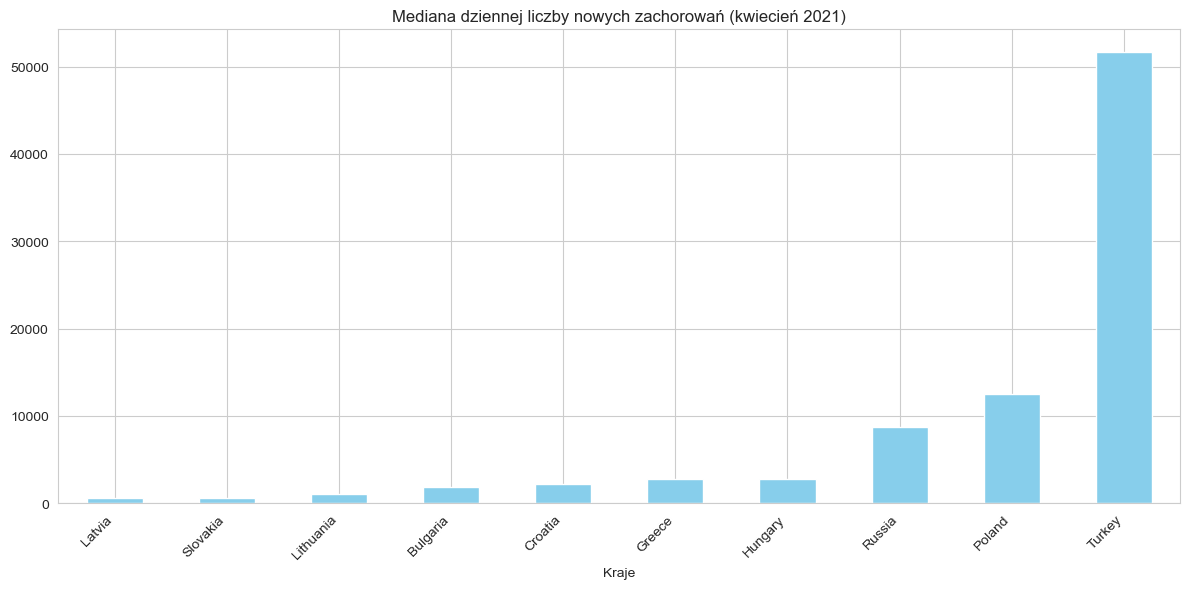

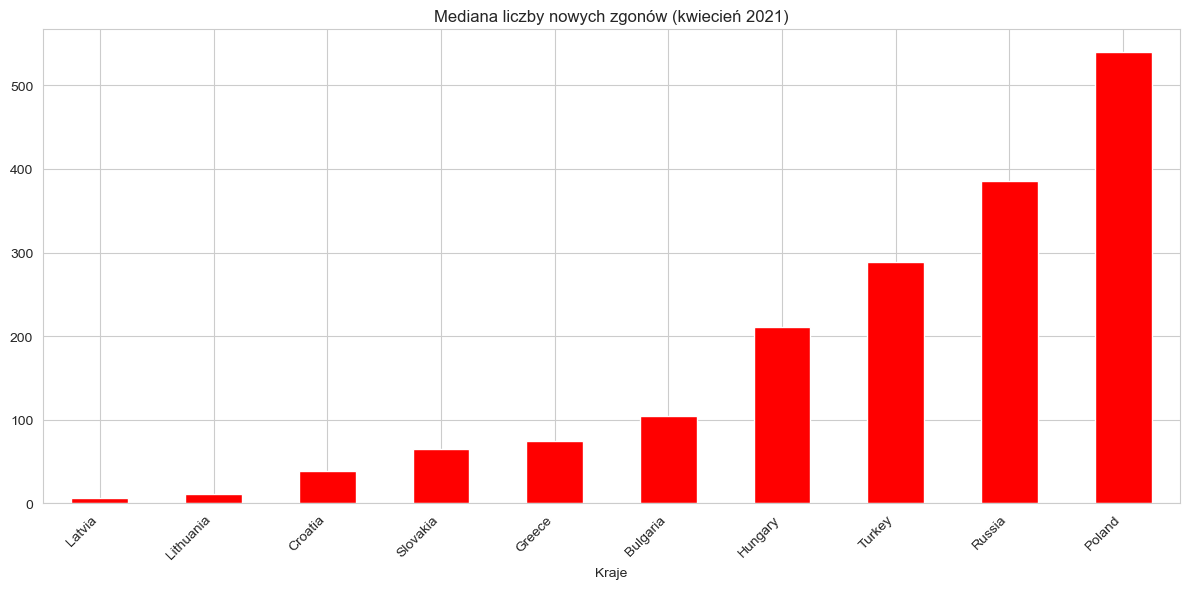

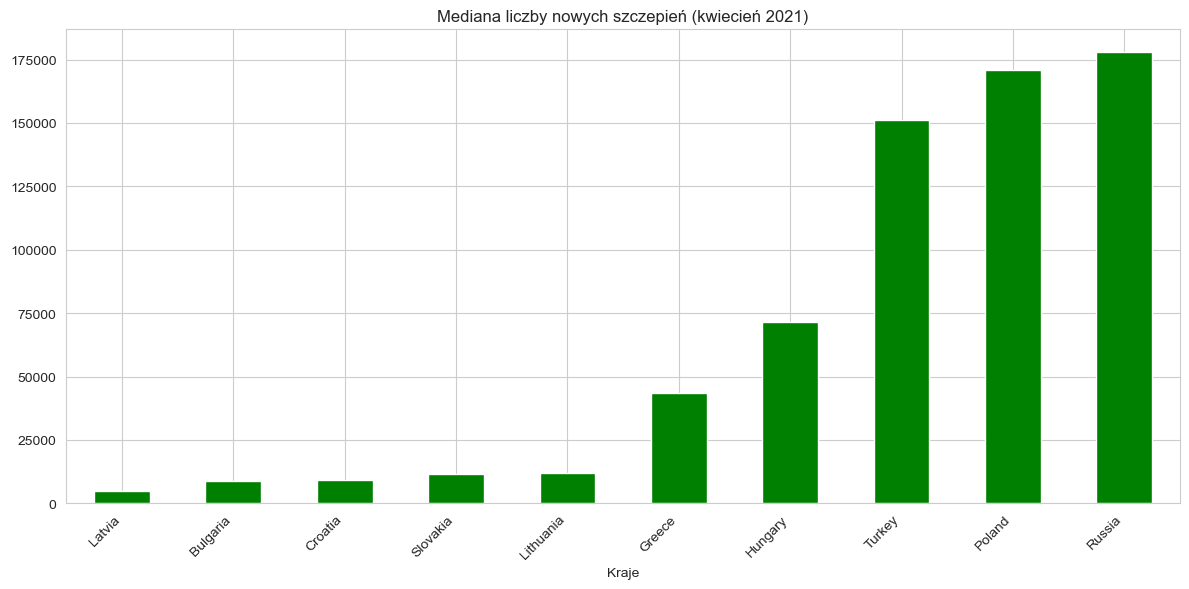

In [46]:
confirmed = df_filtered.groupby("Country_name")["Total_confirmed_cases"].median().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue", figsize=(12, 6))
plt.title("Mediana dziennej liczby nowych zachorowań (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kraje")
plt.tight_layout()
plt.show()

deceased = df_filtered.groupby("Country_name")["Total_new_deceased"].median().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Mediana liczby nowych zgonów (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kraje")
plt.tight_layout()
plt.show()

vaccinations = df_filtered.groupby("Country_name")["Total_new_vaccinations"].median().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Mediana liczby nowych szczepień (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kraje")
plt.tight_layout()
plt.show()


1. Mediana nowych zachorowań potwierdza wcześniejsza obserwacje - Turcja znacząco odstaje od reszty państw, a wyniki (liczby bezwzględne) są mocno związane z liczbą ludnosci danych państw.
2. Mediana nowych śmierci potwierdza wcześniejsze obserwacje - Polska niechlubnie odstaje od reszty pańśtw, a wyniki (liczby bezwzględne) są mocno związane z liczbą ludnosci danych państw.
3. Mediana nowych szczepień potwierdza wcześniejsza obserwacje, że to najbardziej ludne państwa przeprowadzały najwięcej szczepień.
### 3.4. Odchylenie standardowe liczby nowych zachorowań, śmierci i szczepień dla 10 wybranych krajów.

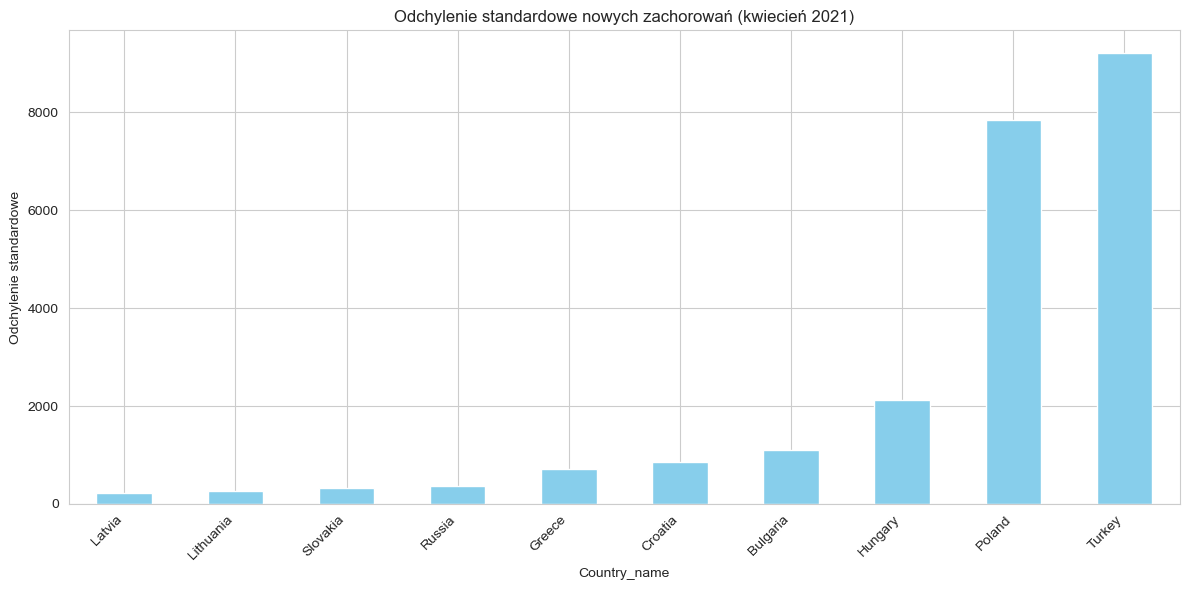

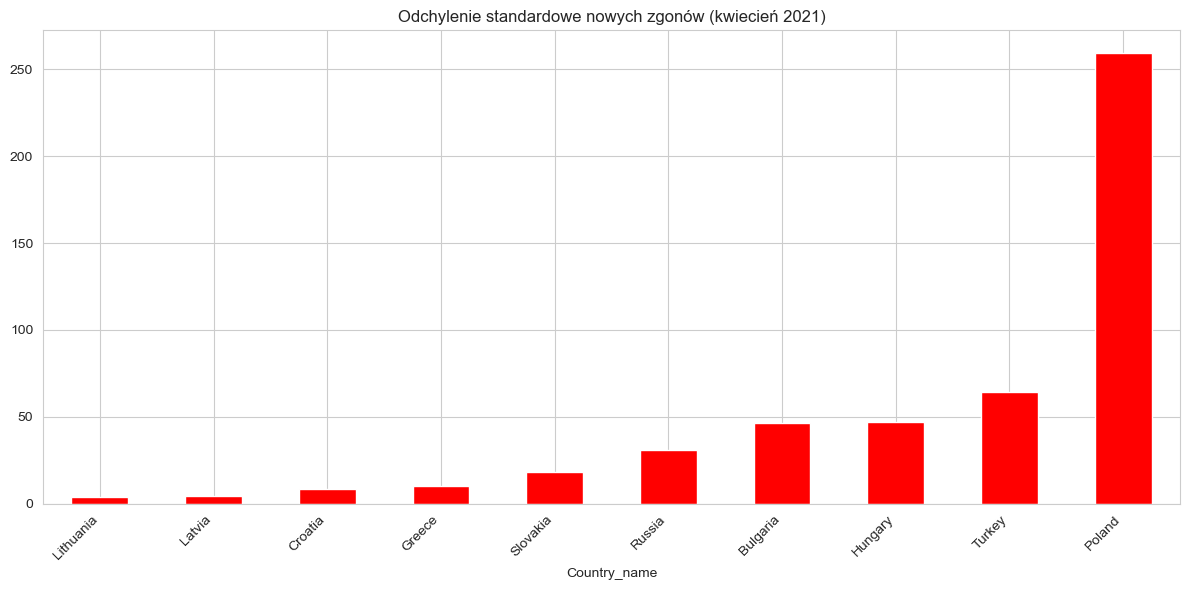

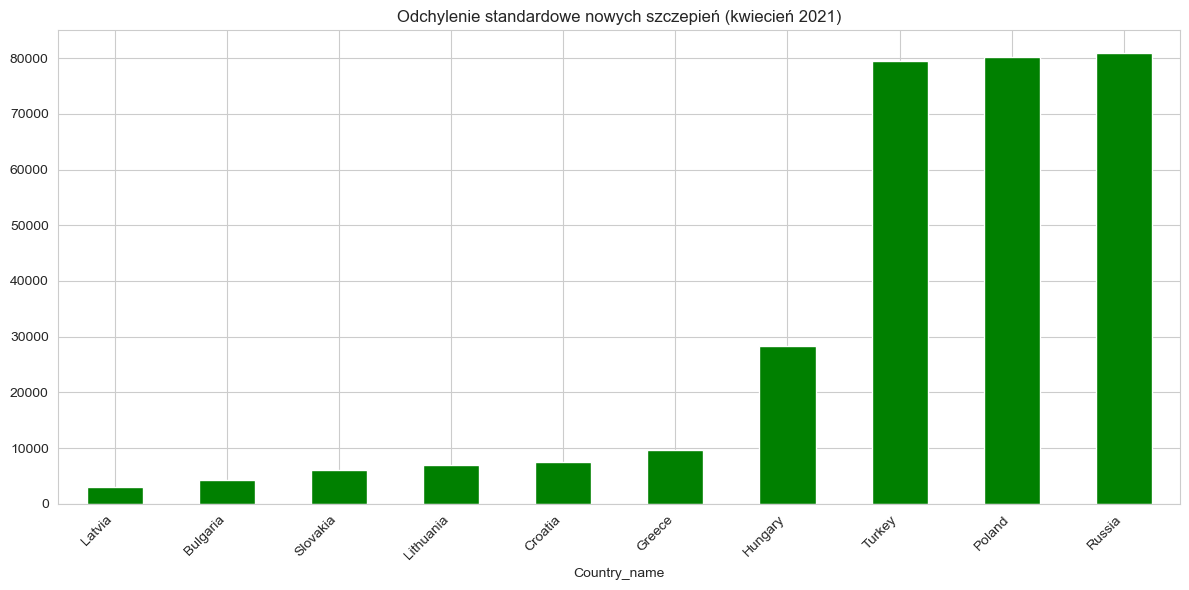

In [47]:
# 3.4.1. Odchylenie standardowe nowych zachorowań
confirmed = df_filtered.groupby("Country_name")["Total_confirmed_cases"].std().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue", figsize=(12, 6))
plt.title("Odchylenie standardowe nowych zachorowań (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Odchylenie standardowe")
plt.tight_layout()
plt.show()

# 3.4.2. Odchylenie standardowe nowych zgonów
deceased = df_filtered.groupby("Country_name")["Total_new_deceased"].std().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Odchylenie standardowe nowych zgonów (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.4.3. Odchylenie standardowe nowych szczepień
vaccinations = df_filtered.groupby("Country_name")["Total_new_vaccinations"].std().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Odchylenie standardowe nowych szczepień (kwiecień 2021)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1. W przypadku nowych zachorowań widać duży "rozstrzał" wartości dla Polski i Turcji.
2. W przypadku nowych śmierci widać duży rozsztrzał wartośći dla Polski, co w połączeniu z wykresem z średnią dzienną zmianą liczby nowych śmierci, pozwala stwierdzić że początek kwietnia był w Polsce dużo bardziej śmiertelny niż jego końcówka.
3. W przypadku liczby nowych szczepień widzimy, że szczególnie na Rosji, Polski i Turcja różnice pomiędzy szczepieniami w poszczególnych dniach były duże, co w połaczeniu z wykresem zmiany średniej dziennej liczby szczepień pozwala stwierdzić że w Rosji i Polsce szczepiono coraz więcej ludzi, a w Turcji prawdopodobnie coraz mniej niż na początku kwietnia.

### 3.5. Minimalna, średnia i maksymalna liczba nowych zachorowań, śmierci i szczepień, a PKB wybranych krajów

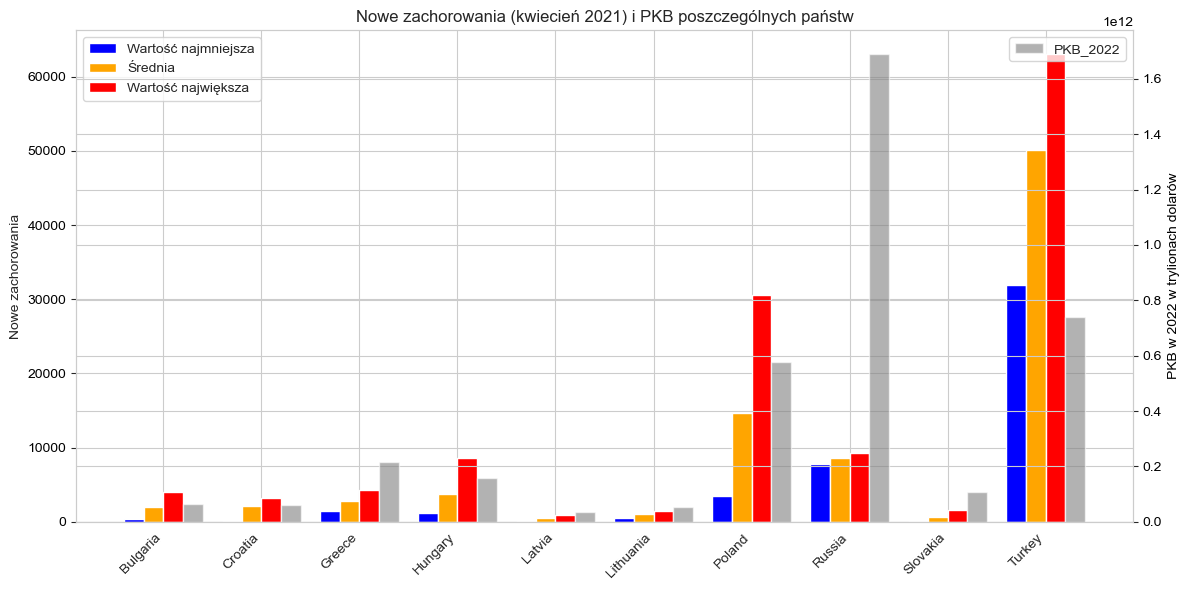

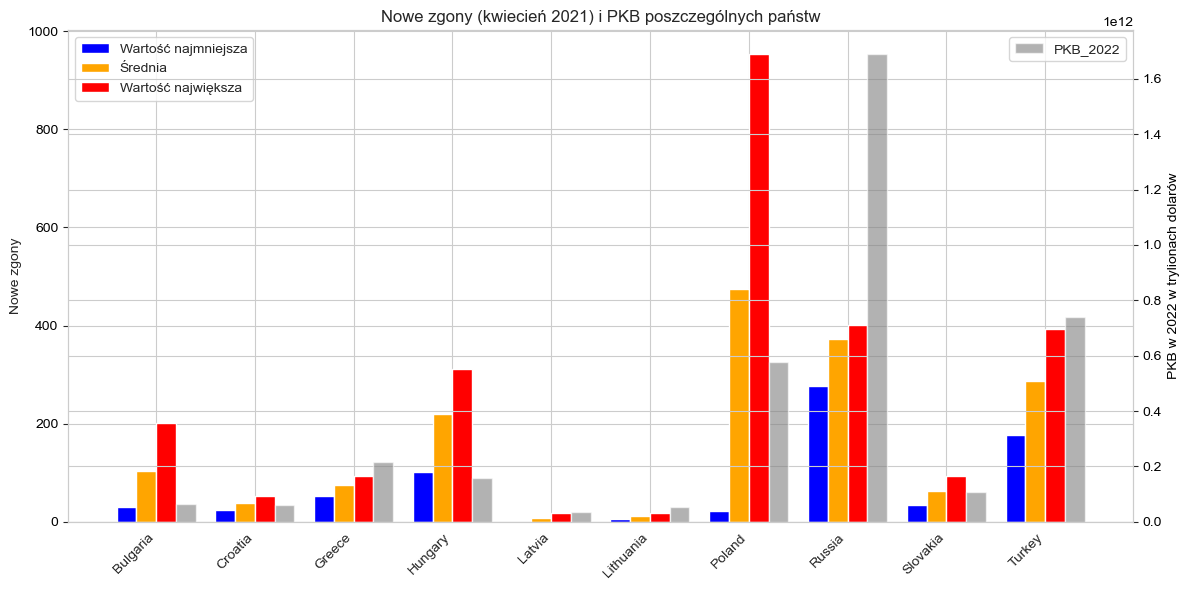

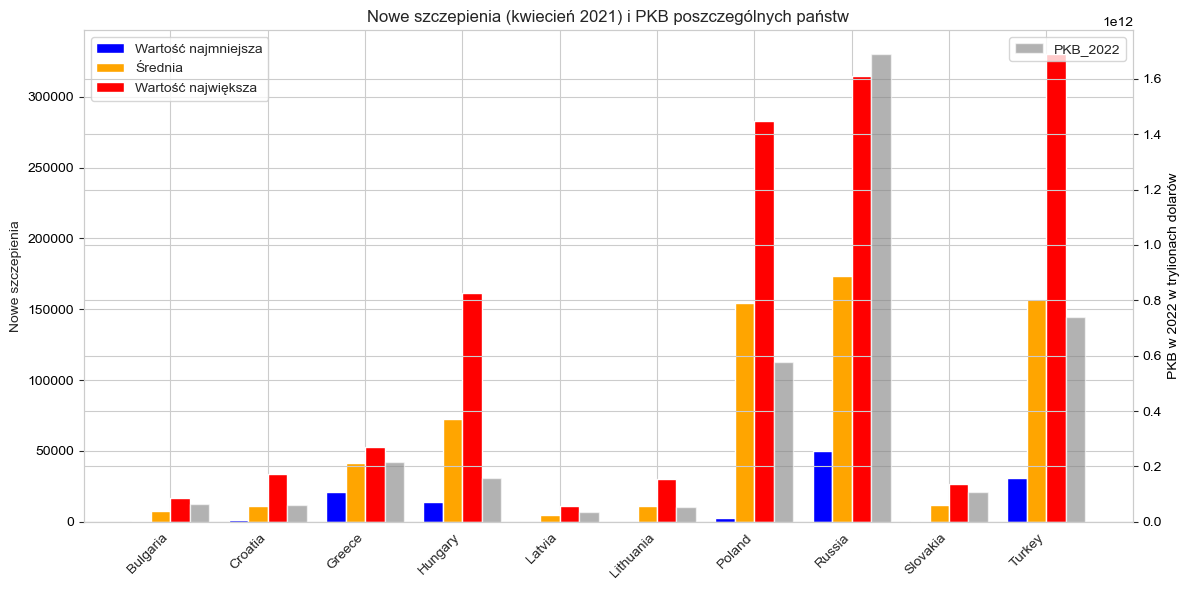

In [48]:
# Obliczenie statystyk dla nowych przypadków, zgonów i szczepień
summary_stats = df_filtered.groupby("Country_name").agg({
    "Total_confirmed_cases": ["min", "mean", "max"],
    "Total_new_deceased": ["min", "mean", "max"],
    "Total_new_vaccinations": ["min", "mean", "max"],
    "GDP_2022": "first"
})

metrics = ["Total_confirmed_cases", "Total_new_deceased", "Total_new_vaccinations"]
titles = ["Nowe zachorowania", "Nowe zgony", "Nowe szczepienia"]
stat_labels = ["Min", "Mean", "Max"]
colors = ["blue", "orange", "red", "gray"]
width = 0.2

for i, metric in enumerate(metrics):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    countries = summary_stats.index

    metric_min = summary_stats[(metric, "min")]
    metric_mean = summary_stats[(metric, "mean")]
    metric_max = summary_stats[(metric, "max")]
    gdp_values = summary_stats[("GDP_2022", "first")]

    x = np.arange(len(countries))
    ax1.bar(x - 1.5 * width, metric_min, width=width, label="Wartość najmniejsza", color=colors[0])
    ax1.bar(x - 0.5 * width, metric_mean, width=width, label="Średnia", color=colors[1])
    ax1.bar(x + 0.5 * width, metric_max, width=width, label="Wartość największa", color=colors[2])
    ax2 = ax1.twinx()
    ax2.bar(x + 1.5 * width, gdp_values, width=width, label="PKB_2022", color=colors[3], alpha=0.6)

    ax1.set_ylabel(titles[i])
    ax1.tick_params(axis='y', labelcolor="black")
    ax2.set_ylabel("PKB w 2022 w trylionach dolarów", color="black")
    ax2.tick_params(axis='y', labelcolor="black", )

    ax1.set_xticks(x)
    ax1.set_xticklabels(countries, rotation=45, ha="right")
    ax1.set_title(f"{titles[i]} (kwiecień 2021) i PKB poszczególnych państw")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

0. Skala:
- liniowa bo wartości zachorowań/śmierci/szczepień są różnicy 0-60000/1000/300000 a PKB/Populacji 0,1-1,7.

1. Zachorowania:
- Turcję, Polskę Węgry i Bułgarięmożemy określić państwami, w których liczba zachorowań była duża w stosunku do PKB.
- Rosja ma stosunkowo mało nowych zachorowań jak na swoje PKB, jest to prawdopodobnie związane z wspomnianą już gęstością zaludnienia tego państwa.
- Pozytywnie można wyróżnić Grecję, Litwę, Łotwę i Słowację, gdzie nawet maksymalna liczba zachorowań jest niska względem słupka  PKB.
2. Śmierci:
- Tutaj widzimy zmianę na fotelu lidera, Bułgaria ma bardzo tragiczny stosunek zgonów do GPD, z kolei Turcja jak chodzi o śmiertelność to nie poradziła sobie aż tak źle jak mogłoby się wydawać z zachorowań - gorsza od niej jest choćby Polska, Węgry(oba bardzo złe wyniki), Chorwacja czy - o dziwo - Słowacja.
- Dodatkowo dla Polski i Bułgarii możemy wyróżnić bardzo dużą różnicę pomiędzy najmniejszą i największą liczbą zgonów.
3. Szczepienia:
- Widzimy bardzo dużą liczbę szczepień w porównaniu z PKB na Węgrzech, Litwie, Chorwacji, Polsce, Turcji i Grecji (w tych państwach średnia liczba dziennych szczepień przewyższa lub dorównuje słupkowi PKB).
- Tylko dla Rosji liczba maksymalna szczepień nie przebiła słupka z PKB, a we wszystkich innych pańśtwach - tak, a dodatkowo średnia w większości z nich także przekroczyła lub przynajmniej zrównała się z tym słupkiem.
- We wszystkich państwach widać dużą różnicę pomiędzy minimalną i maksymalną liczbą szczepień.

### 3.6. Minimalna, średnia i maksymalna liczba nowych zachorowań, szczepień i śmierci, a populacja 10 wybranych krajów.

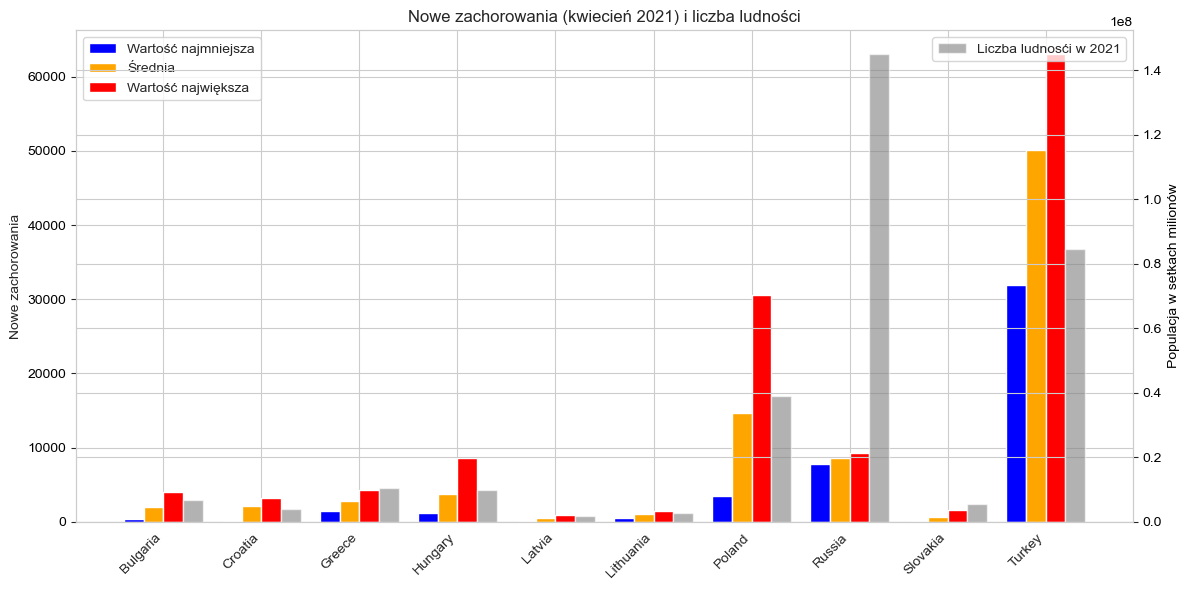

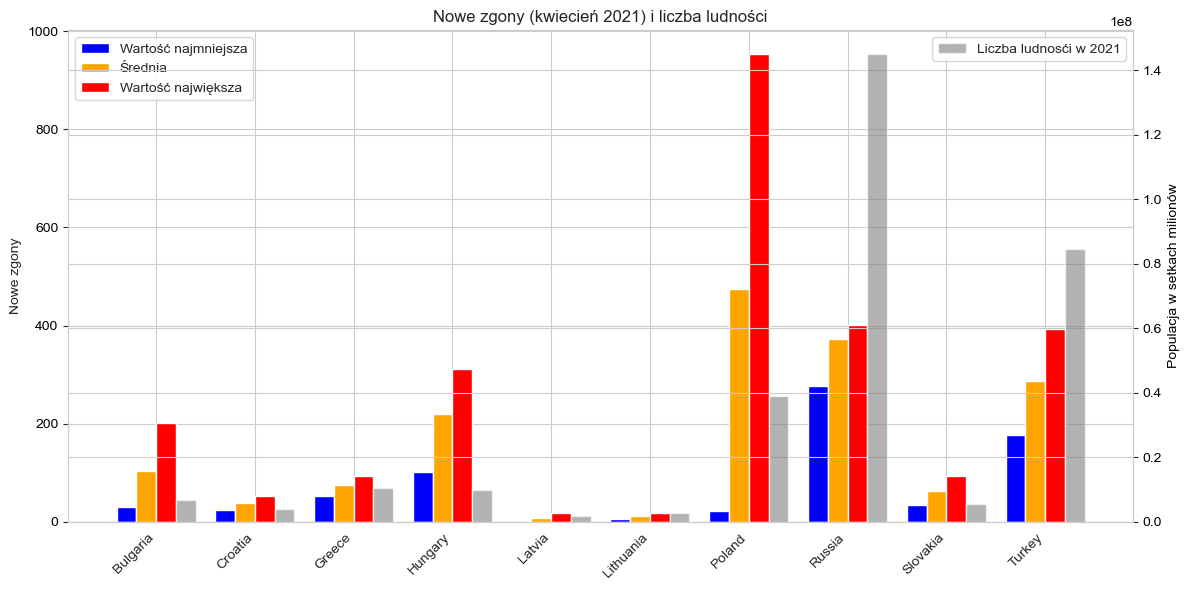

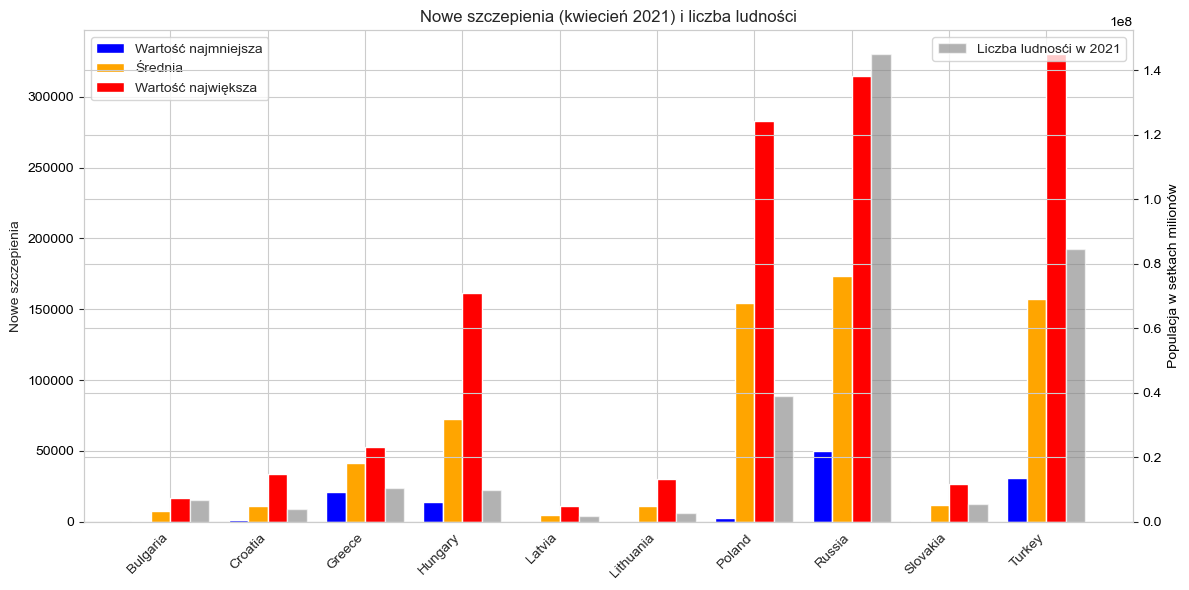

In [49]:
summary_stats = df_filtered.groupby("Country_name").agg({
    "Total_confirmed_cases": ["min", "mean", "max"],
    "Total_new_deceased": ["min", "mean", "max"],
    "Total_new_vaccinations": ["min", "mean", "max"],
    "2021 Population": "first"
})

metrics = ["Total_confirmed_cases", "Total_new_deceased", "Total_new_vaccinations"]
titles = ["Nowe zachorowania", "Nowe zgony", "Nowe szczepienia"]
stat_labels = ["Min", "Mean", "Max"]
colors = ["blue", "orange", "red", "gray"]
width = 0.2

for i, metric in enumerate(metrics):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    countries = summary_stats.index

    metric_min = summary_stats[(metric, "min")]
    metric_mean = summary_stats[(metric, "mean")]
    metric_max = summary_stats[(metric, "max")]
    population_values = summary_stats[("2021 Population", "first")]

    x = np.arange(len(countries))
    ax1.bar(x - 1.5 * width, metric_min, width=width, label="Wartość najmniejsza", color=colors[0])
    ax1.bar(x - 0.5 * width, metric_mean, width=width, label="Średnia", color=colors[1])
    ax1.bar(x + 0.5 * width, metric_max, width=width, label="Wartość największa", color=colors[2])
    ax2 = ax1.twinx()
    ax2.bar(x + 1.5 * width, population_values, width=width, label="Liczba ludnosći w 2021", color=colors[3], alpha=0.6)

    ax1.set_ylabel(titles[i])
    ax1.tick_params(axis='y', labelcolor="black")
    ax2.set_ylabel("Populacja w setkach milionów", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    ax1.set_xticks(x)
    ax1.set_xticklabels(countries, rotation=45, ha="right")
    ax1.set_title(f"{titles[i]} (kwiecień 2021) i liczba ludności")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

1. Nowe zachorowania:
- Podobnie jak przy PKB - Turcja bardzo dużo Polska, Węgry i Bułgaria też dużo.
2. Nowe śmierci:
- Podobnie jak przy PKB - Węgry, Bułgaria i Polska najgorzej.
3. Nowe zaszczepienia:
- Widzimy bardzo dużą liczbę szczepień w porównaniu z liczbą ludności na Węgrzech, Litwie, Chorwacji, Polsce, Turcji i Grecji.
- Rosja znowu najgorzej.

### Wnioski końcowe:
- Turcja spełniła założenie początkowe, że kraj o najgorszym PKB per capita będzie miał najgorsze wyniki pod względem zachorowań/śmierci, jednocześnie jednak w tym kraju przeprowadzano dużó szczepień, więc nie można go aż tak potępiać.
- Polska wygląda na prowadzącą pod względem śmierci, co biorąc pod uwagę tylko PKB per capita byłoby bardzo dziwne.
- Rosja pod wszystkimi 3 względami radziła sobie zadzwiająco dobrze jak na słaby stosunek PKB do liczby ludności, prawdopodobnie jednym z czynników może być bardzo mała gęstość zaludnienia tego kraju w porównaniu do pozostalych.
- Takie kraje jak Bułgaria, która pod wzgledem PKB per capita wyglądała dosyć słabo również znajduje się w czołówce najgorszych wyników.
- Krajami, ktore w analizowanym okresie radziły sobie względnie dobrze (albo lepiej od reszty) można by nazwać Słowację, Litwę i Łotwę.
- W liczbach bezwzglednych widać dużą różnicę pomiędzy nowymi szczepieniami a zachorowaniami/śmierciami, co jest pozytywnym zjawiskiem.

### Część 4 (poziom podstawowy) - normalizacja danych

4.1.-4.3. Normalizacja zachorowań, śmierci i zaszczepień

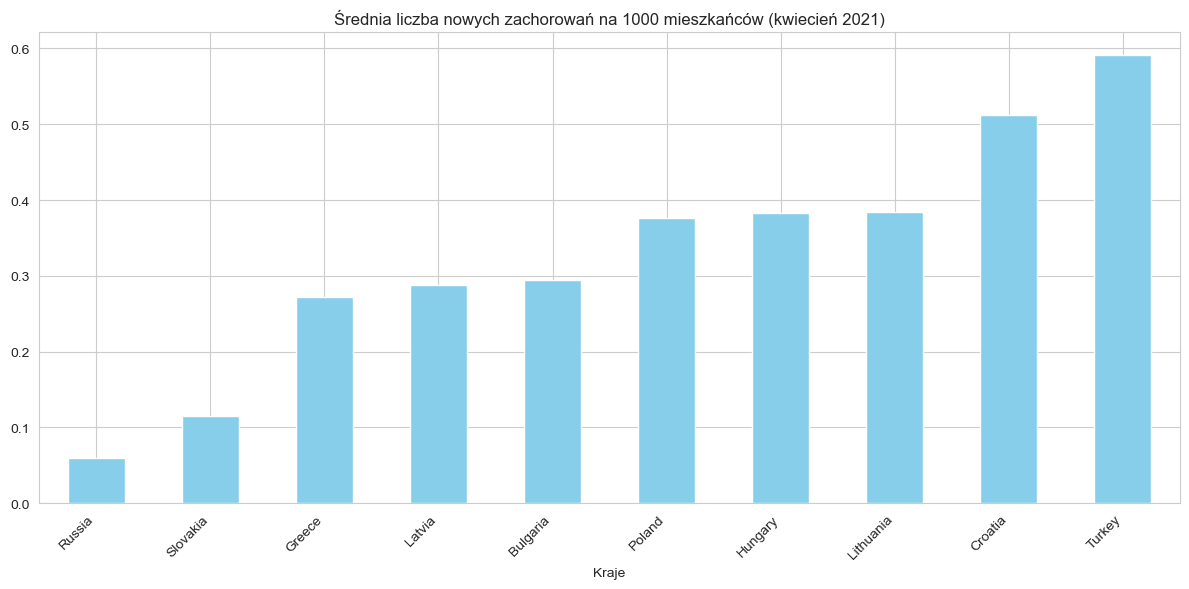

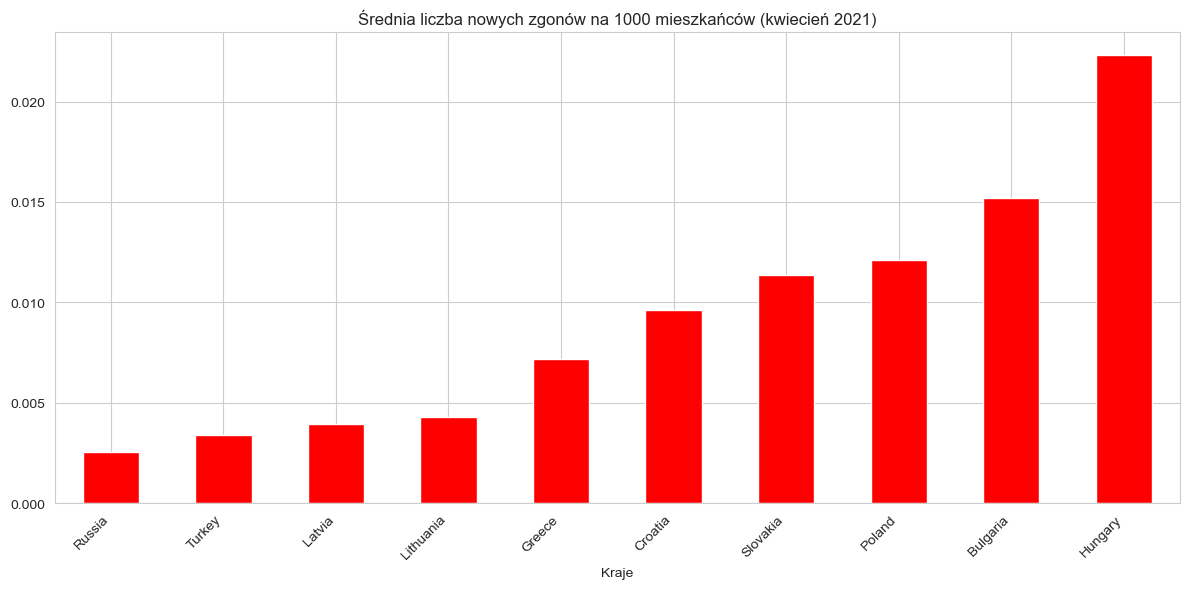

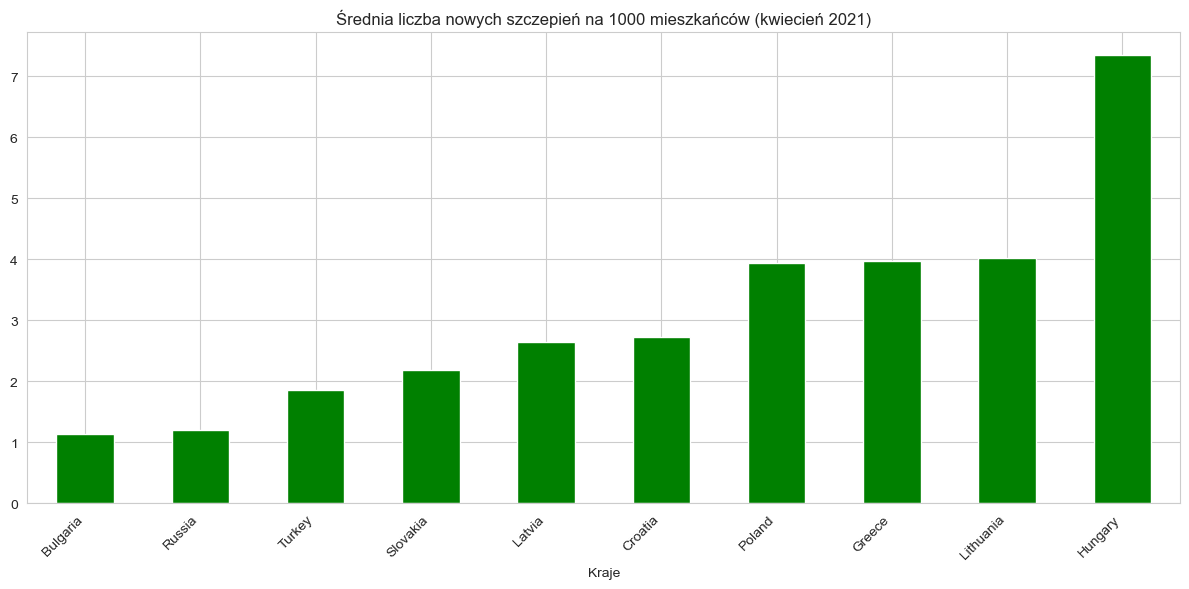

In [50]:
#4.0 Normalizacja na 1000 mieszkańcow
df_filtered["Cases_per_1000"] = (df_filtered["Total_confirmed_cases"] / df_filtered["2021 Population"]) * 1000
df_filtered["Vaccinations_per_1000"] = (df_filtered["Total_new_vaccinations"] / df_filtered["2021 Population"]) * 1000
df_filtered["Deceased_per_1000"] = (df_filtered["Total_new_deceased"] / df_filtered["2021 Population"]) * 1000
#4.1
confirmed = df_filtered.groupby("Country_name")["Cases_per_1000"].mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue")
plt.title("Średnia liczba nowych zachorowań na 1000 mieszkańców (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#4.2
deceased = df_filtered.groupby("Country_name")["Deceased_per_1000"].mean().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Średnia liczba nowych zgonów na 1000 mieszkańców (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#4.3
vaccinations = df_filtered.groupby("Country_name")["Vaccinations_per_1000"].mean().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Średnia liczba nowych szczepień na 1000 mieszkańców (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1. Zachorowania:
- Turcja na prowadzeniu zgodnie z wcześniejszymi analizami
- Niespodziewane 2. i 3. miejsce Chorwacji i Litwy - nie było to aż tak widoczne przy wcześniejszej skali.
2. Śmierci:
- Polska nie wypada tutaj aż tak koszmarnie jak przy liczbach bezwzględnych.
- Bułgaria i Węgry bez większego zaskoczenia, były to państwa które też zwracały naszą uwagę przy śmiertelności.
- Lekkim zdziwieniem jest 4. miejsce Słowacji, która wcześniej wydawała się jednym z lepiej wypadających krajów.
3. Szczepienia:
- Okazuje się, że w Rosji i Turcji liczba szczepień nie była aż tak niesamowita jaksię wydawała wcześniej.
- Odstająco dobry wynik Węgier, którego też byśmy się nie spodziewali po wcześniejszych wizualizacjach.
4. Wnioski ogólne:
- Przy sporym rozstrzale liczby ludności jaki mamy w naszych państwach można było od początku zakładać, że to właśnie tego typu normalizacja przedstawi najrealniejsze wartości.

4.4 Pełne zaszczepienia (wszystkimi dostępnymi dawkami) (1. dodatkowy wykres)

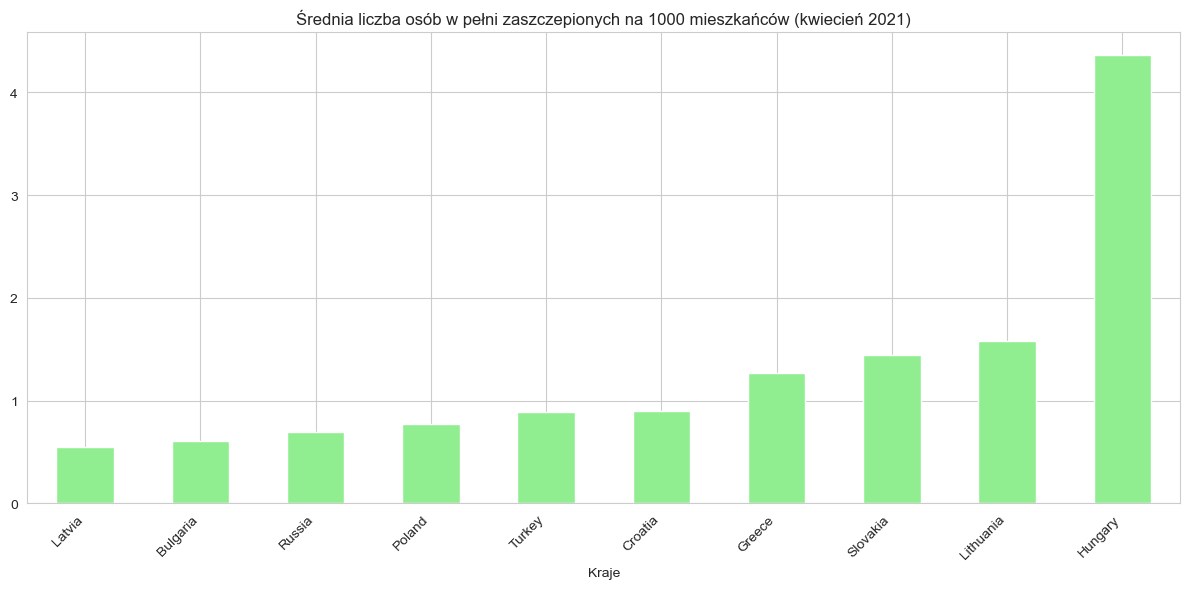

In [51]:
df_filtered["Fully_vaccinated_1000"] = (df_filtered["New_persons_fully_vaccinated"] / df_filtered["2021 Population"]) * 1000
confirmed = df_filtered.groupby("Country_name")["Fully_vaccinated_1000"].mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="lightgreen")
plt.title("Średnia liczba osób w pełni zaszczepionych na 1000 mieszkańców (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- Bardzo podobnie do liczby nowych szczepień.

4.5 Liczba testów (2. dodatkowy wykres)

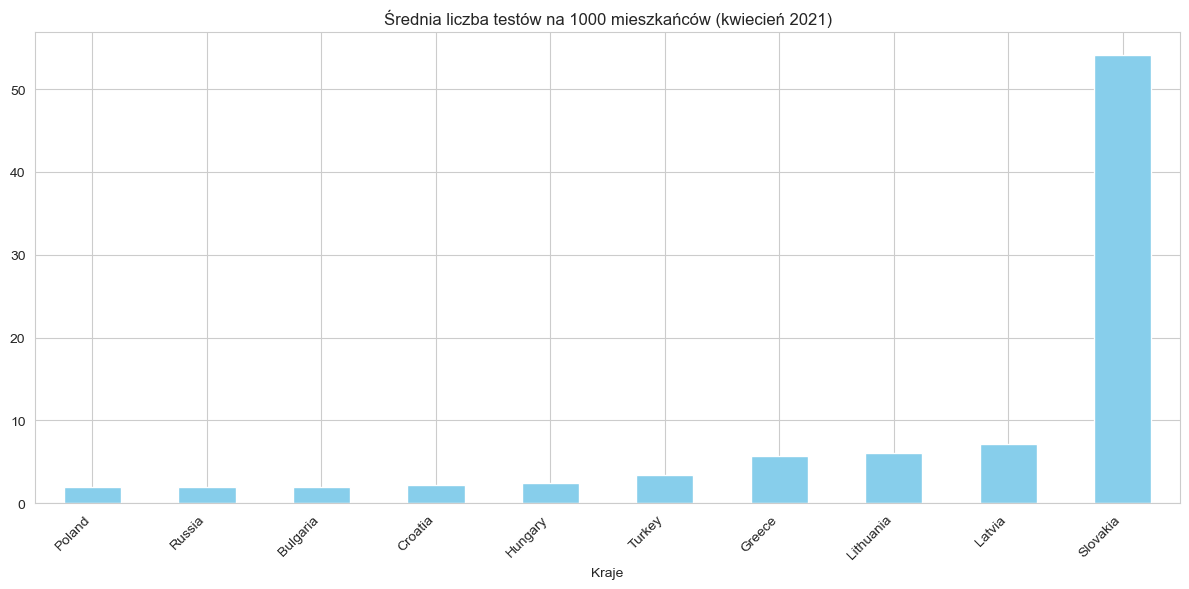

In [52]:
df_filtered["Total_tested_per_1000"] = (df_filtered["Total_tested"] / df_filtered["2021 Population"]) * 1000
confirmed = df_filtered.groupby("Country_name")["Total_tested_per_1000"].mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue")
plt.title("Średnia liczba testów na 1000 mieszkańców (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- Nic ciekawego oprócz niesamowitej liczby testów na Słowacji.

4.6 Normalizacja względem ludności miejskiej (3 dodatkowe wykresy)

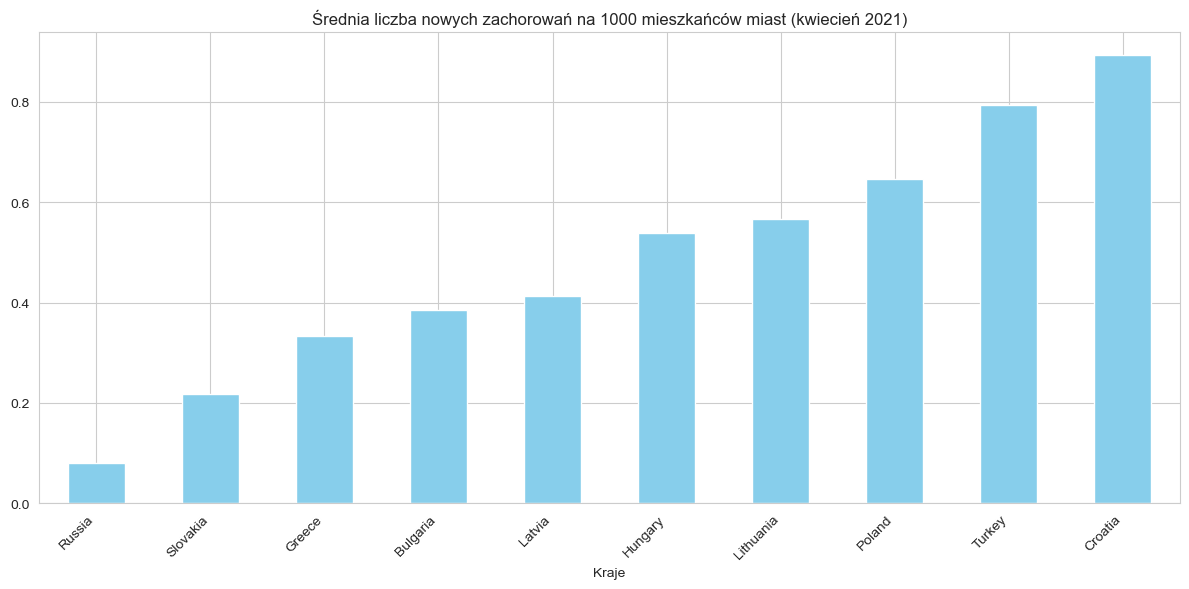

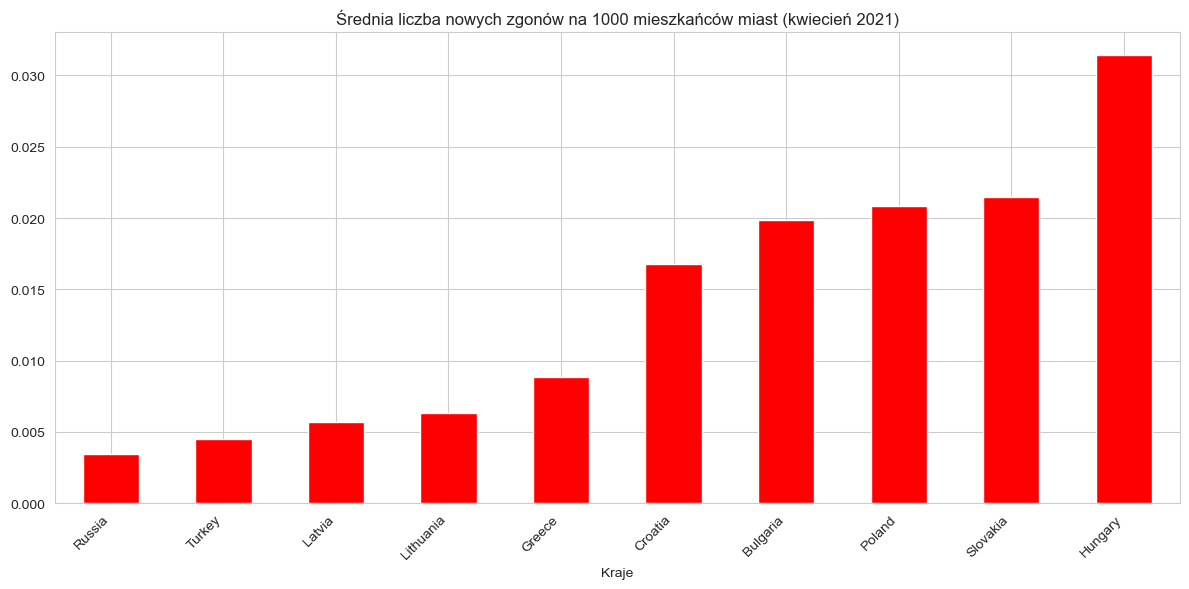

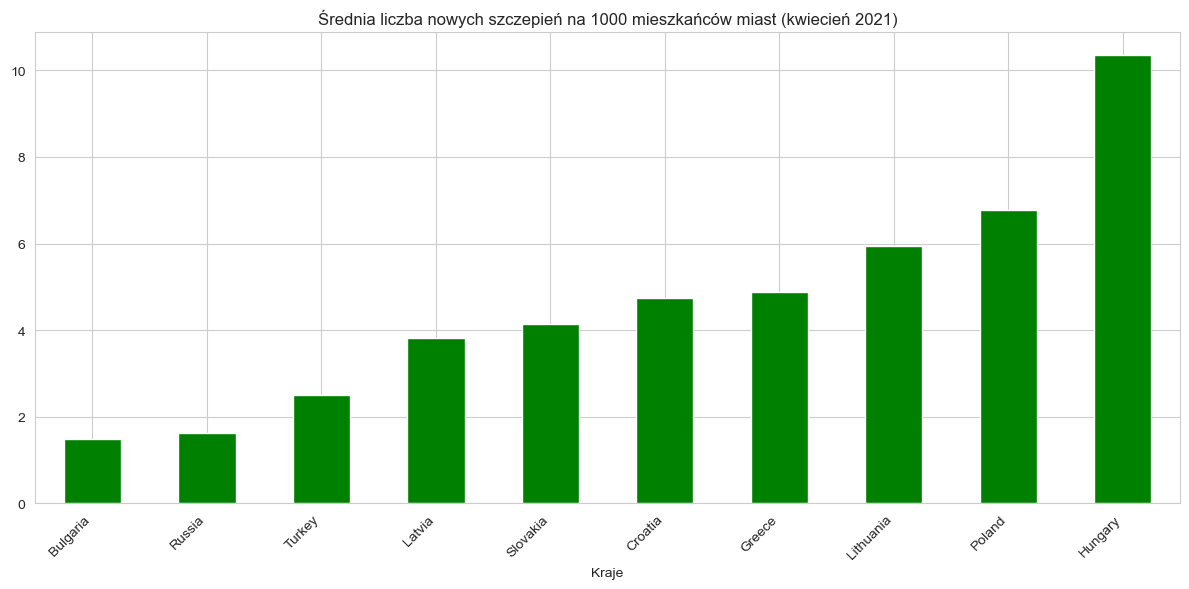

In [53]:
df_filtered["Cases_per_1000_urban"] = (df_filtered["Total_confirmed_cases"] / df_filtered["Urban Population"]) * 1000
df_filtered["Vaccinations_per_1000_urban"] = (df_filtered["Total_new_vaccinations"] / df_filtered["Urban Population"]) * 1000
df_filtered["Deceased_per_1000_urban"] = (df_filtered["Total_new_deceased"] / df_filtered["Urban Population"]) * 1000

confirmed = df_filtered.groupby("Country_name")["Cases_per_1000_urban"].mean().sort_values()
plt.figure(figsize=(12, 6))
confirmed.plot(kind="bar", color="skyblue")
plt.title("Średnia liczba nowych zachorowań na 1000 mieszkańców miast (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

deceased = df_filtered.groupby("Country_name")["Deceased_per_1000_urban"].mean().sort_values()
plt.figure(figsize=(12, 6))
deceased.plot(kind="bar", color="red")
plt.title("Średnia liczba nowych zgonów na 1000 mieszkańców miast (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

vaccinations = df_filtered.groupby("Country_name")["Vaccinations_per_1000_urban"].mean().sort_values()
plt.figure(figsize=(12, 6))
vaccinations.plot(kind="bar", color="green")
plt.title("Średnia liczba nowych szczepień na 1000 mieszkańców miast (kwiecień 2021)")
plt.xlabel("Kraje")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

0. Nie jest to oczywiście normalizacja idealna, ponieważ analizujemy liczbę wszystkich zachorowań/śmierci/szczepień zamiast zachorowan/śmierci/szczepień w miastach, ale nie mamy takich danych, a jednak wiemy, że to przede wszystkim w miastach z jednej strony wirusy rozprzestrzeniają się najszybciej, z drugiej strony szczepień też było najwięcej (no bo tam mieszka najwięcej ludzi). Pozwala nam to spojrzeć trochę inaczaczej na analizowane wyniki.
1. W przypadku zachorowań w miastach najbardziej byśmy byli zarażeni mieszkając w Chorwacji, a nie Turcji, która wydawało się, że cały czas przoduje w tej kategorii.
2. W przypadku śmierci nie mamy za dużych zmian w pozycjach w rankingu.
3. W przypadku liczby przeprowadzanych testów też nie mamy większych zmian, z patriotycznego obowiązku możemy wypunktować, że Polska w tej kategorii awansowała o 2 pozycje w stosunku do liczby testów na całkowite 1000 os.

### Część 5 (poziom dodatkowy) - korelacja danych

### 5.1. Liczba nowych zachorowań, szczepień i zgonów, a liczba nowych zachorowań, szczepień i zgonów.
<br>Spodziewane korelacje:
- dodatnia pomiędzy wszystkimi parametrami, ale z większymi wartościami pomiędzy zachorowaniami a zgonami.

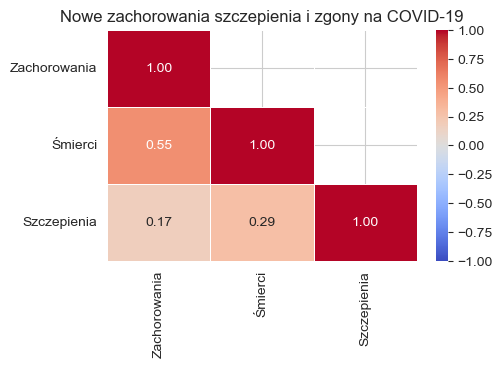

In [54]:
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations']
short_labels = ['Zachorowania', 'Śmierci', 'Szczepienia']
df_corr=df_data[cols]
corr=df_corr.corr()
plt.figure(figsize=(5, 3))
mask = np.triu(corr, k=1)
mask[corr == 1] = False
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe zachorowania szczepienia i zgony na COVID-19");

Wyniki zgodne z założeniami - obie korelacje na plusie.
 - kiedy więcej ludzi zostaje zarażonych, to też więcej ludzi umiera.
  - zachorowania i śmierci skłaniają ludzi do szczepienia się ale informacje o zgonach mają większe siłę przebicia.


### 5.2. Liczba nowych zachorowań, szczepień, zgonów, a łączna liczba zachorowań, szczepień, zgonów.
Spodziewane korelacje:
- dodatnia pomiędzy wszystkimi parametrami, najwyższe wskaźniki dla tych samych rodzajów parametrów (np. nowe zachorowania i łączne zachorowania).

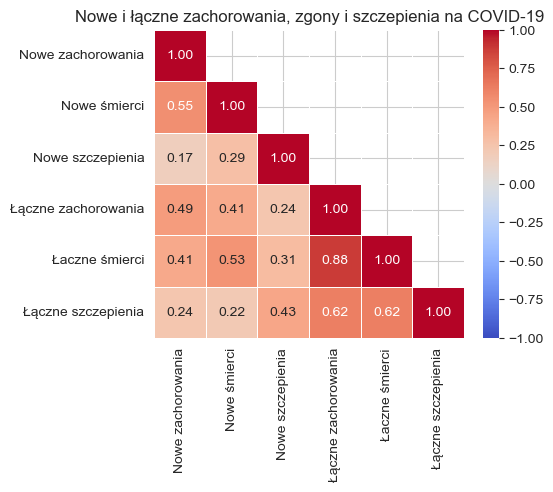

In [61]:
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations',
   'Total_cases', 'Total_deceased', 'Total_vaccinations']
short_labels = ['Nowe zachorowania', 'Nowe śmierci', 'Nowe szczepienia',
                'Łączne zachorowania', 'Łaczne śmierci', 'Łączne szczepienia']
df_corr=df_data[cols]
corr=df_corr.corr()
mask = np.triu(corr, k=1)
mask[corr == 1] = False
plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe i łączne zachorowania, zgony i szczepienia na COVID-19");

Zgodnie z założeniami - wszystkie korelacje są pozytywne, największe są pomiędzy tymi samymi rodzajami parametrów (nowe zachorowania-łączne zachorowania itd.). Dodatkowo widzimy duże powiązanie nowych zachorowań z łącznymi śmierciami i vice versa.

### 5.3. Wskaźniki gospodarcze, a liczba nowych zachorowań, szczepień i zgonów.
Spodziewane korelacje:
- dodatnia pomiędzy PKB per capita a liczbą nowych szczepień,
- ujemna pomiędzy PKB per capita a liczbą nowych zachorowań i zgonów,
- w przypadku zwykłego PKB ciężko powiedzieć, bo z jednej strony większe PKB powinno oznaczać bogatsze pańśtwo, z drugiej strony PKB rośnie często wraz ze wzrostem liczby ludności danego kraju, więc nie jest to taki jasny wyznacznik jakości życia. Nie zdziwią nas ani ujemne ani dodatnie powiązania tej wartości.

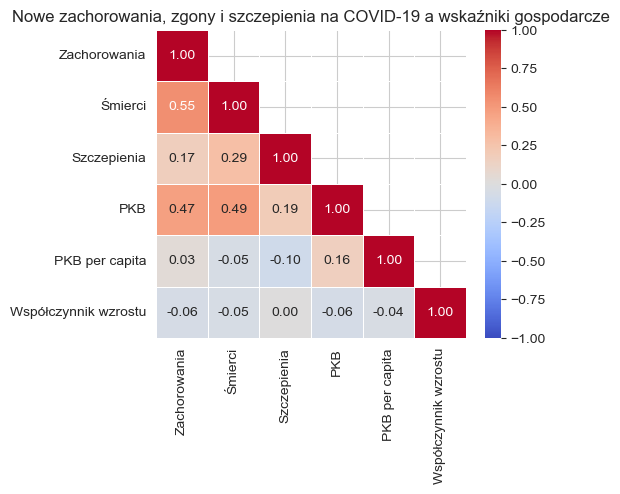

In [56]:
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations',
    'GDP_2022', 'gdp_per_capita_usd', 'Growth Rate']
short_labels = ['Zachorowania', 'Śmierci', 'Szczepienia',
                'PKB', 'PKB per capita', 'Współczynnik wzrostu']
df_corr=df_data[cols]
corr=df_corr.corr()
mask = np.triu(corr, k=1)
mask[corr == 1] = False
plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe zachorowania, zgony i szczepienia na COVID-19 a wskaźniki gospodarcze");

1. PKB - dla zachorowań i śmierci działa tak jak prawdopodobnie będzie z liczbą ludności - korelacja dodatnia, dla szczepień deliktnie na plus bo pewnie jest sporo krajów z wysokim PKB, ale biednych, gdzie trudno było zakupić/wyedukować ludzi na temat szczepień.
2. PKB per capita - zgodnie z założeniami, jak widać "dobrobyt" państwa najłatwiej było przekuć w dużą liczbę szczepień, a najtrudniej było zapobiec rozprzestrzenianiu się wirusa.
3. Współczynnik wzrostu (jak szybko rośnie PKB) - podobne wartości jak dla PKB per capita ale w odwrotnej kolejności, czyli kraje które szybko się rozwijają lepiej radziły sobie z ograniczeniem zarażeń niż z przeprowadzaniem szczepień (ciekawe).

### 5.4. Parametry demograficzne, a liczba nowych zachorowań, szczepień i zgonów.
Spodziewane korelacje:
- dodatnia pomiędzy wskaźnikami demograficznymi a liczbą zachorowań, śmierci i szczepień (szczególnie z tymi ostatnimi). Największa korelacja dla gęstości zaludnienia, najmniejsza dla ogólnej liczby populacji.

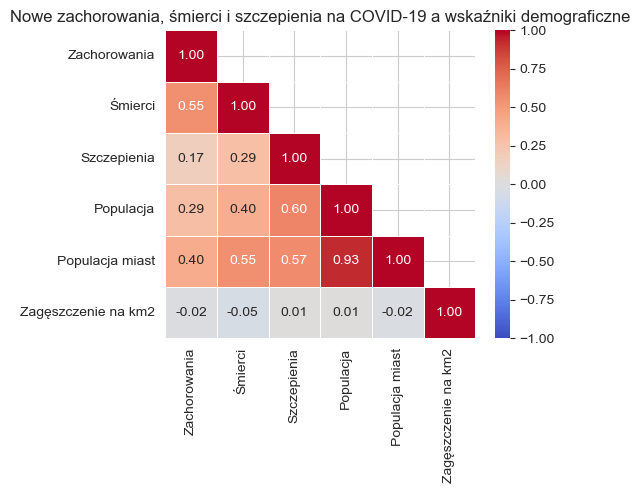

In [57]:
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations',
    '2021 Population', 'Urban Population', 'Density_per_km']
short_labels = ['Zachorowania', 'Śmierci', 'Szczepienia',
                'Populacja', 'Populacja miast', 'Zagęszczenie na km2']
df_corr=df_data[cols]
corr=df_corr.corr()
mask = np.triu(corr, k=1)
mask[corr == 1] = False
plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe zachorowania, śmierci i szczepienia na COVID-19 a wskaźniki demograficzne");

1. Populacja - spora korelacja dla szczepień, najmniejsza dla zachorowań - ciekawe bo spodziewalibyśmy się odwrotnej kolejności.
2. Populacja miast - dużo mniejsze zróżnicowanie w korelacji z śmiercią a szczepieniami, zachorowań dalej wyraźnie niżej.
3. Zagęszczenie ludności na km2 - o dziwo brak korelacji, a dla zachorowań i śmierci nawet tendencja bardziej na minus niż plus.
4. W tym przypadku nasze predykcje były chyba najbardziej "przestrzelone" spośród wszystkich podpunktów.

### 5.5.1 Liczba nowych zachorowań, szczepień i zgonów a inflacja, bezrobocie i współczynnik morderstw (3 dodatkowe korelacje).
Spodziewane korelacje:
- Zarówno wysoka inflacja, bezrobocie jak i wspólczynnik morderstw powinny dotyczyć państw z niską wartością PKB per capita (państwa biedne i do tego z większą liczbą ludności), dlatego mozemy spodziewać się dodatniej korelacji pomiędzy tymi czynnikami a liczbą zachorowań i zgonów, a ujemną pomiędzymi nimi a szczepieniami.

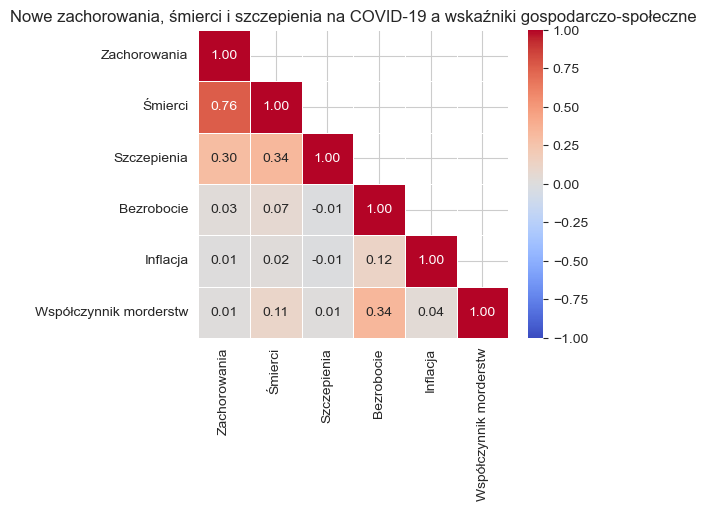

In [58]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_2021 = df_data[df_data['date'].dt.year == 2021]
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations',
    'Unemployment_2021', 'Inflation_2021', 'Murders_Rate_2021']
short_labels = ['Zachorowania', 'Śmierci', 'Szczepienia',
                'Bezrobocie', 'Inflacja', 'Współczynnik morderstw']
df_corr=df_2021[cols]
corr=df_corr.corr()
mask = np.triu(corr, k=1)
mask[corr == 1] = False
plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe zachorowania, śmierci i szczepienia na COVID-19 a wskaźniki gospodarczo-społeczne");

1. Bezrobocie - brak specjalnych zależności, spośród naszych 3 parametrów widzimy, że powiązanie ze zgonami jest największe ale to tyle.
2. Inflacja - o dziwo mniejsze zróżnicowanie niż w przypadku bezrobocia. Także brak korelacji.
3. Współczynnik morderstw - delikatne powiązanie ze zgonami, ale także brak większych korelacji.
4. Co prawda nie dotyczy to COVIDA, ale widzimy ciekawą, jedyną jaśniejszą korelację dla bezrobocia i współczynika morderstw.

### 5.5.2 Liczba nowych zachorowań, szczepień i zgonów a obostrzenia dotyczące zamykania szkół, miejsc pracy, wydarzeń publicznych i zgromadzeń publicznych (3 dodatkowe korelacje).
Spodziewane korelacje:
- Wysoka wartość w restrykcjach oznacza duże ograniczenia w spotkaniach międzyludzkich, więc dotyczyły one prawdopodobnie sytuacji, kiedy sytuacja pandemiczna była najgorsza w danym kraju, czyli generowałboy to dużą korelację z zachorowaniami i śmierciami, z drugiej strony wysokie obostrzenia mogły być utrzymywane jeszcze długo po "peaku", albo z drugiej strony niektóre kraje wprowadzały "za swobodne" lub "za surowe" obostrzenia w stosunku do sytuacji. Więc pewnie wyjdzie jakaś delikatna korelacja na poziomie 0,15-0,30.
- Z szczepieniami ciężko powiedzieć, teoretycznie w krajach z surowymi restrykcjami powinna być gorsza sytuacja epidemiologiczna w danym momencie, czyli z jednej strony wielu ludziom powinno zależeć na szczepieniu się, z drugiej komunikacja w tych warunkach może być utrudniona, a ludzie mogli odczuwać większy strach przed wyjściem z domu. Prawdopodobnie będzie to też jakaś wartość dodatnia, ale mniejsza niż dla zachorowań/śmierci.


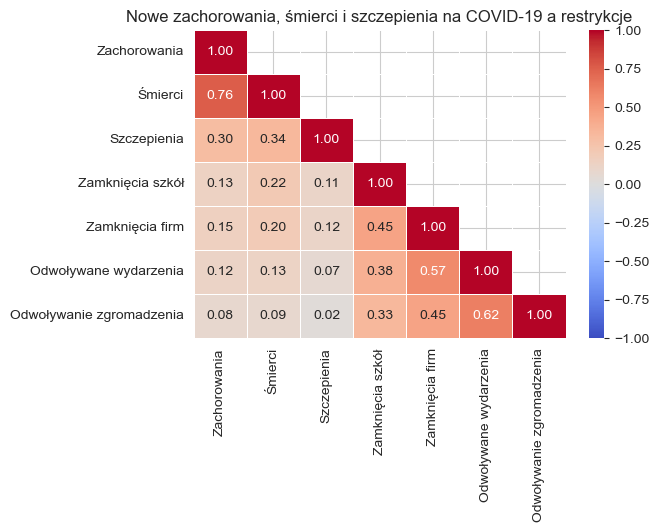

In [59]:
cols = ['Total_confirmed_cases', 'Total_new_deceased', 'Total_new_vaccinations',
    'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings']
short_labels = ['Zachorowania', 'Śmierci', 'Szczepienia',
                'Zamknięcia szkół', 'Zamknięcia firm', 'Odwoływane wydarzenia', 'Odwoływanie zgromadzenia']
df_corr=df_2021[cols]
corr=df_corr.corr()
mask = np.triu(corr, k=1)
mask[corr == 1] = False
plt.figure(figsize=(6, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(short_labels)
ax.set_yticklabels(short_labels)
plt.title("Nowe zachorowania, śmierci i szczepienia na COVID-19 a restrykcje");

1. Zamknięcia szkół - mała korelacja z zachorowaniami i szczepiami, co ciekawe 2x większa dla śmierci.
2. Zamknięcia firm (miejsc pracy) - podobne korelacje jak dla szkół
3. Restrykcje dotyczące organizacji wydarzeń publicznych - podobna korelacja dla zachorowań, mniejsza dla śmierci i szczepień.
4. Restrykcje dotyczące organizacji zgromadzeń publicznych - korelacja jeszcze mniejsza niż dla wydarzeń.
Otrzymane wyniki są w większości przypadków mniejsze niż zakładaliśmy, aczkolwiek jest utrzymana tendencja wartości dodatnich i większej korelacji dla zachorowań i śmierci niż szczepień.